# Setting

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 200 # 해상도 설정
plt.rcParams['font.family'] = 'NanumSquare' # plt 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨지는 문제 해결

## Merge 작업
- https://mizykk.tistory.com/82
- how = 'outer'로 합침

In [2]:
for mart_name in ['a','b','c','d']:
    # 변수명 지정
    gds_prep_name = 'gds_' + mart_name + '_prep'
    tr_dtl_name = 'tr_dtl_list_' + mart_name
    tr_name = 'tr_list_' + mart_name

    # Data Load
    gds_mart_prep = pd.read_csv('data/'+ gds_prep_name + '.csv')
    tr_dtl_mart = pd.read_csv('data/' + tr_dtl_name + '.csv')
    tr_mart = pd.read_csv('data/' + tr_name + '.csv')

    # Merge
    merge_mart = pd.merge(gds_mart_prep[['PLU_CD', 'GDS_NM']], tr_dtl_mart[['SAL_DT','STR_CD','POS_NO','TRAN_NO','PLU_CD', 'SALE_QTY', 'SALE_PRC', 'SALE_AMT']], how='outer', on='PLU_CD')
    merge_hour_mart = pd.merge(merge_mart, tr_mart[['SAL_DT','STR_CD','POS_NO','TRAN_NO', 'REAL_SAL_DT', 'REAL_SAL_TTM']], how='outer', on=['SAL_DT','STR_CD','POS_NO','TRAN_NO'])

    # Outlier Drop(D마트)
    if merge_hour_mart[merge_hour_mart['REAL_SAL_TTM'] == 26].shape[0] != 0: 
        merge_hour_mart = merge_hour_mart.drop(merge_hour_mart[merge_hour_mart['REAL_SAL_TTM'] == 26].index)
    if merge_hour_mart[merge_hour_mart['REAL_SAL_TTM'] == 15].shape[0] != 0: 
        merge_hour_mart = merge_hour_mart.drop(merge_hour_mart[merge_hour_mart['REAL_SAL_TTM'] == 15].index)
    if merge_hour_mart[merge_hour_mart['REAL_SAL_TTM'] == 2].shape[0] != 0: 
        merge_hour_mart = merge_hour_mart.drop(merge_hour_mart[merge_hour_mart['REAL_SAL_TTM'] == 2].index)

    # B마트 전용
    if mart_name == 'b':
        # Drop Null Value
        merge_hour_mart = merge_hour_mart.dropna(subset=['REAL_SAL_DT','REAL_SAL_TTM'], how='any') # https://cosmosproject.tistory.com/308

        # float to int
        merge_hour_mart['REAL_SAL_DT'] = merge_hour_mart['REAL_SAL_DT'].astype(int)
        merge_hour_mart['REAL_SAL_TTM'] = merge_hour_mart['REAL_SAL_TTM'].astype(int)

    # int to str
    merge_hour_mart['REAL_SAL_DT'] = merge_hour_mart['REAL_SAL_DT'].astype(str)
    merge_hour_mart['REAL_SAL_TTM'] = merge_hour_mart['REAL_SAL_TTM'].astype(str)

    # 시(24시간제)를 0으로 채워진 10진수로 정리
    for idx in range(len(merge_hour_mart.REAL_SAL_TTM)):
        x = merge_hour_mart.REAL_SAL_TTM.iloc[idx]
        if len(x) == 6:
          continue
        elif len(x) == 5:
          x = '0' + x

    # 일자와 시간대를 결합 
    merge_hour_mart['DT_TTM'] = merge_hour_mart['REAL_SAL_DT'] + merge_hour_mart['REAL_SAL_TTM']

    # str to datetime
    merge_hour_mart['DT_TTM'] = merge_hour_mart['DT_TTM'].apply(lambda x: datetime.strptime(x,'%Y%m%d%H%M%S')) # https://junyoru.tistory.com/134, https://docs.python.org/ko/3/library/datetime.html#strftime-strptime-behavior

    # Save data
    merge_hour_mart.to_csv('data/' + 'merge_' + mart_name + '.csv')

In [3]:
merge_a = pd.read_csv('data/merge_a.csv', index_col=0)
merge_b = pd.read_csv('data/merge_b.csv', index_col=0)
merge_c = pd.read_csv('data/merge_c.csv', index_col=0)
merge_d = pd.read_csv('data/merge_d.csv', index_col=0)

# 콩나물

## A마트

In [4]:
# int to str
merge_a['REAL_SAL_DT'] = merge_a['REAL_SAL_DT'].astype(str)

# str to datetime
merge_a['REAL_SAL_DT'] = merge_a['REAL_SAL_DT'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
merge_a['DT_TTM'] = pd.to_datetime(merge_a['DT_TTM'])

# Extract
merge_a['DT_TTM_Year'] = merge_a['DT_TTM'].dt.year # Year
merge_a['DT_TTM_Month'] = merge_a['DT_TTM'].dt.month # Month
merge_a['DT_TTM_Day'] = merge_a['DT_TTM'].dt.day # Day
merge_a['DT_TTM_Hour'] = merge_a['DT_TTM'].dt.hour # Hour
merge_a['DT_TTM_Week'] = merge_a['DT_TTM'].dt.week # Week
merge_a['DT_TTM_Week_4'] = (merge_a['DT_TTM_Week'] % 4) + 1 # Week % 4
merge_a['DT_TTM_Week_5'] = (merge_a['DT_TTM_Week'] % 5) + 1 # Week % 5
merge_a['DT_TTM_Day_of_the_Week'] = merge_a['DT_TTM'].dt.day_name() # Day of the Week

# A마트의 저울식품인 콩나물 merge
cnm_a = merge_a[(merge_a['PLU_CD'] == 201307) | (merge_a['PLU_CD'] == 201308)]

# 일자별
a = cnm_a.groupby('REAL_SAL_DT').size()

## C마트

In [5]:
# int to str
merge_c['REAL_SAL_DT'] = merge_c['REAL_SAL_DT'].astype(str)

# str to datetime
merge_c['REAL_SAL_DT'] = merge_c['REAL_SAL_DT'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
merge_c['DT_TTM'] = pd.to_datetime(merge_c['DT_TTM'])

# Extract
merge_c['DT_TTM_Year'] = merge_c['DT_TTM'].dt.year # Year
merge_c['DT_TTM_Month'] = merge_c['DT_TTM'].dt.month # Month
merge_c['DT_TTM_Day'] = merge_c['DT_TTM'].dt.day # Day
merge_c['DT_TTM_Hour'] = merge_c['DT_TTM'].dt.hour # Hour
merge_c['DT_TTM_Week'] = merge_c['DT_TTM'].dt.week # Week
merge_c['DT_TTM_Week_4'] = (merge_c['DT_TTM_Week'] % 4) + 1 # Week % 4
merge_c['DT_TTM_Week_5'] = (merge_c['DT_TTM_Week'] % 5) + 1 # Week % 5
merge_c['DT_TTM_Day_of_the_Week'] = merge_c['DT_TTM'].dt.day_name() # Day of the Week

# C마트의 저울식품인 콩나물 select
cnm_c = merge_c[(merge_c['PLU_CD'] == 205249)]

# 일자별
c = cnm_c.groupby('REAL_SAL_DT').size()

## Graph

<AxesSubplot:title={'center':'C마트'}, xlabel='DT_TTM_Week_4', ylabel='count'>

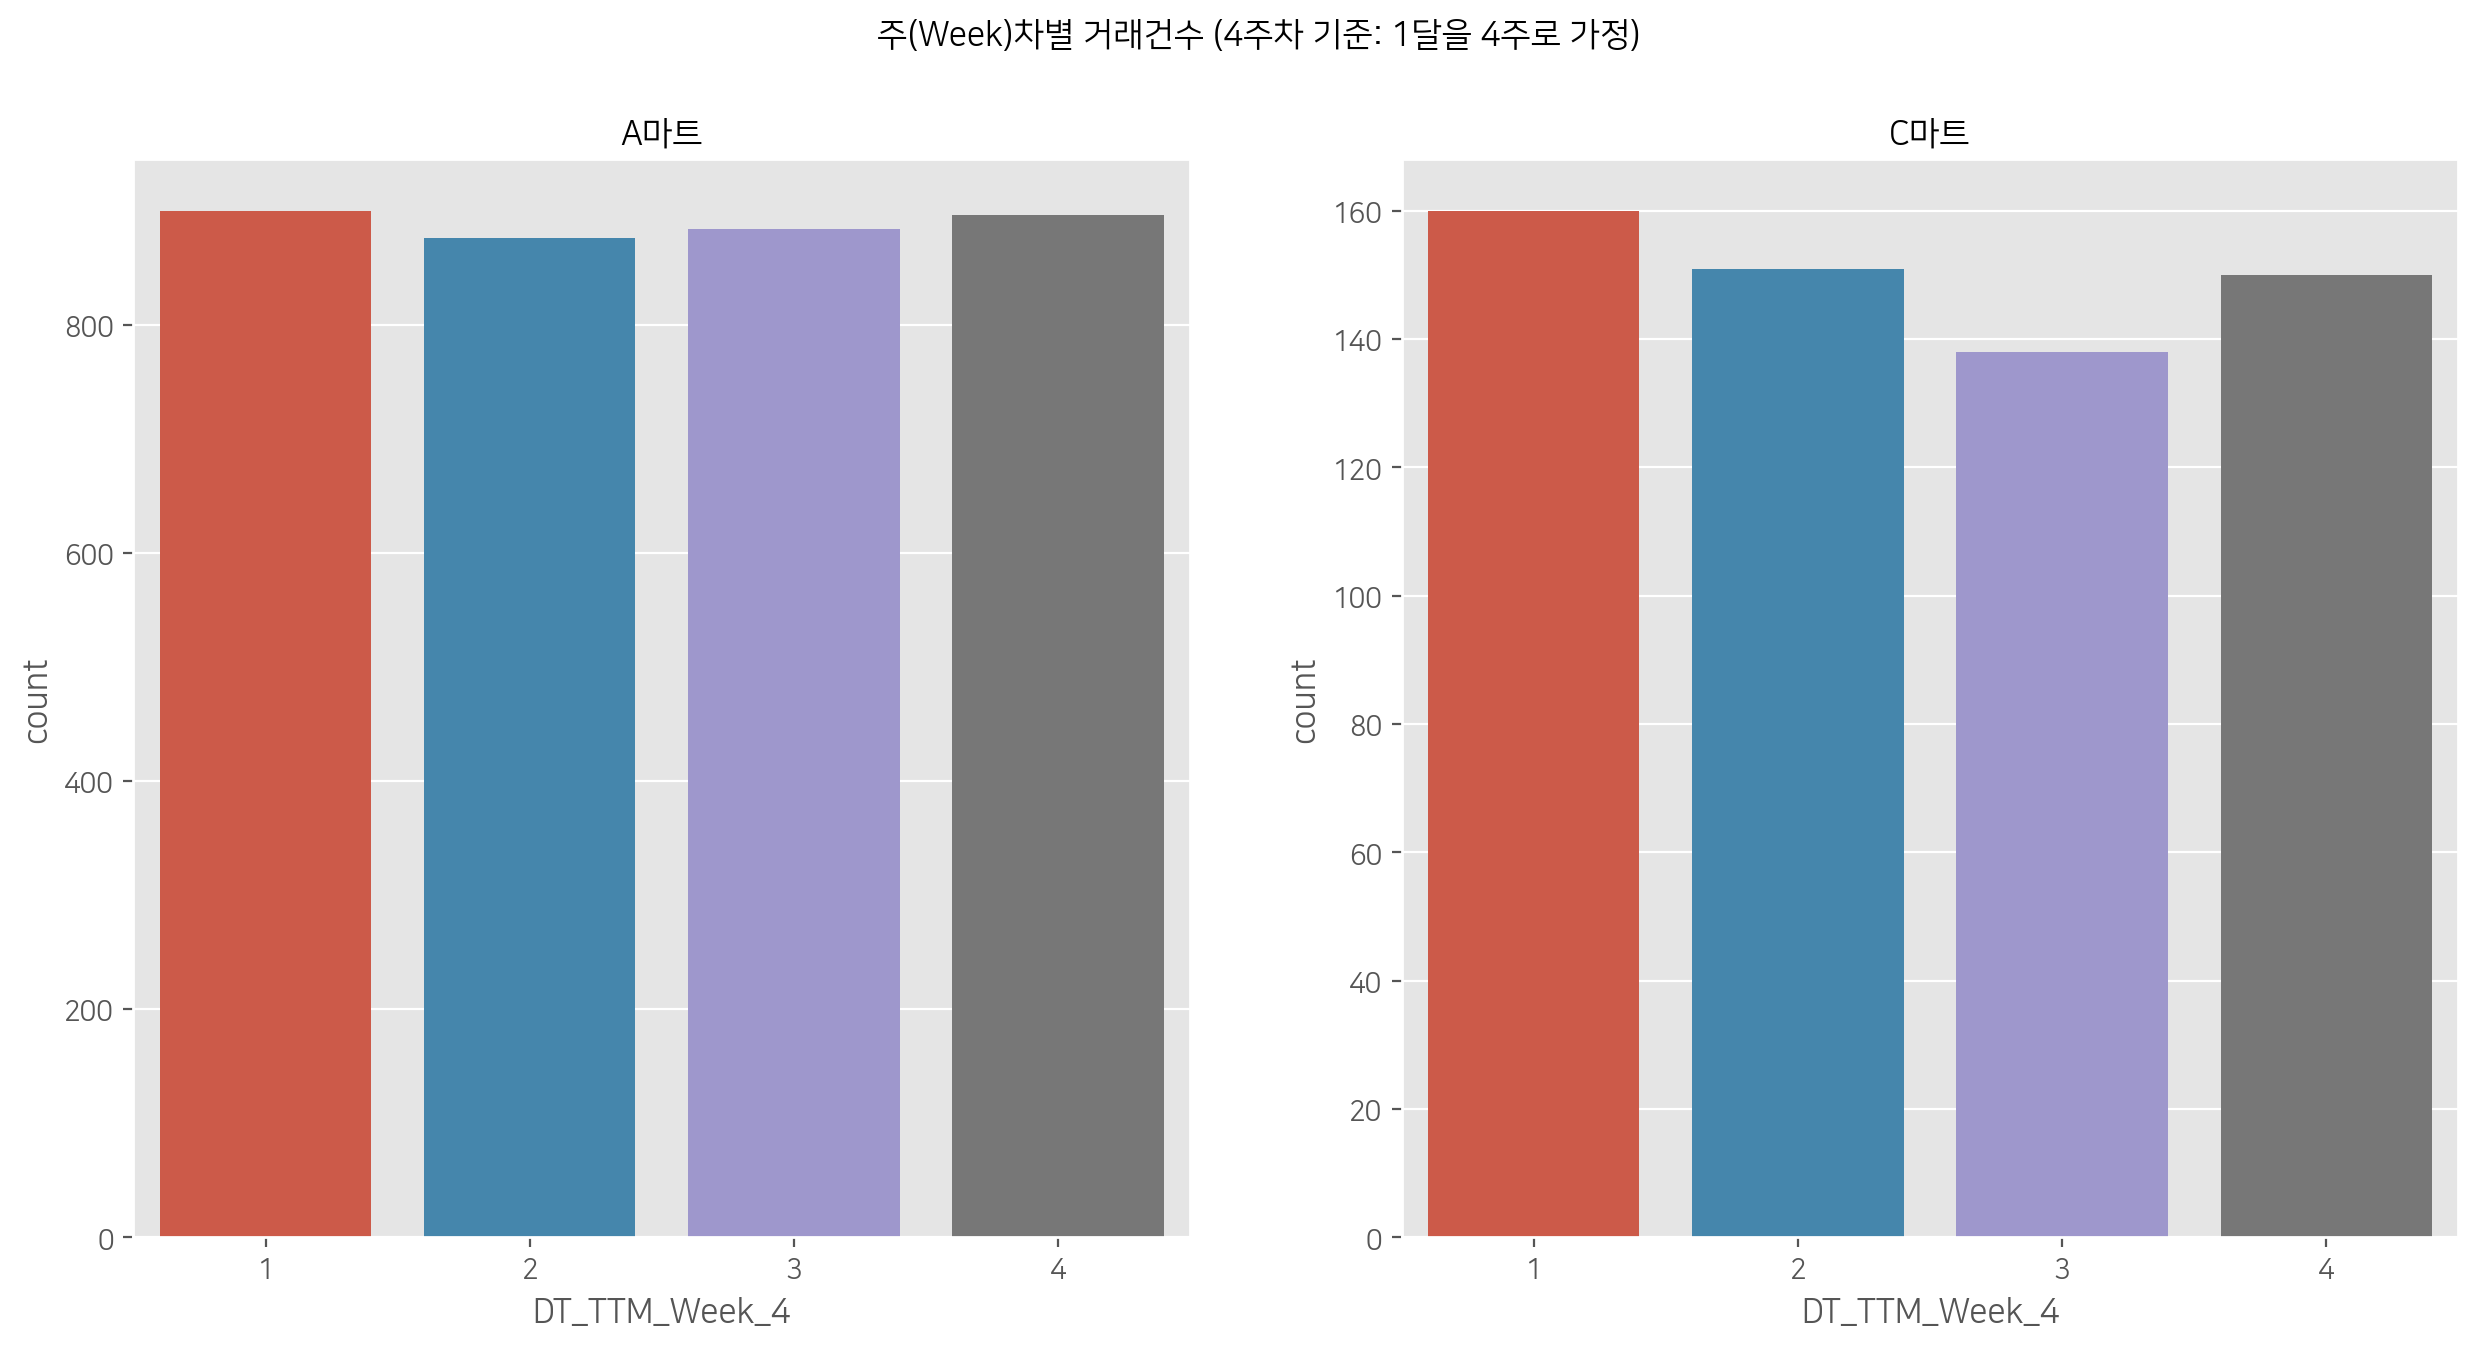

In [6]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')
plt.suptitle('주(Week)차별 거래건수 (4주차 기준: 1달을 4주로 가정)', fontweight='bold', size = 12)

plt.subplot(121)
plt.title('A마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_a['DT_TTM_Week_4'])

plt.subplot(122)
plt.title('C마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_c['DT_TTM_Week_4'])

<AxesSubplot:title={'center':'C마트'}, xlabel='DT_TTM_Week_5', ylabel='count'>

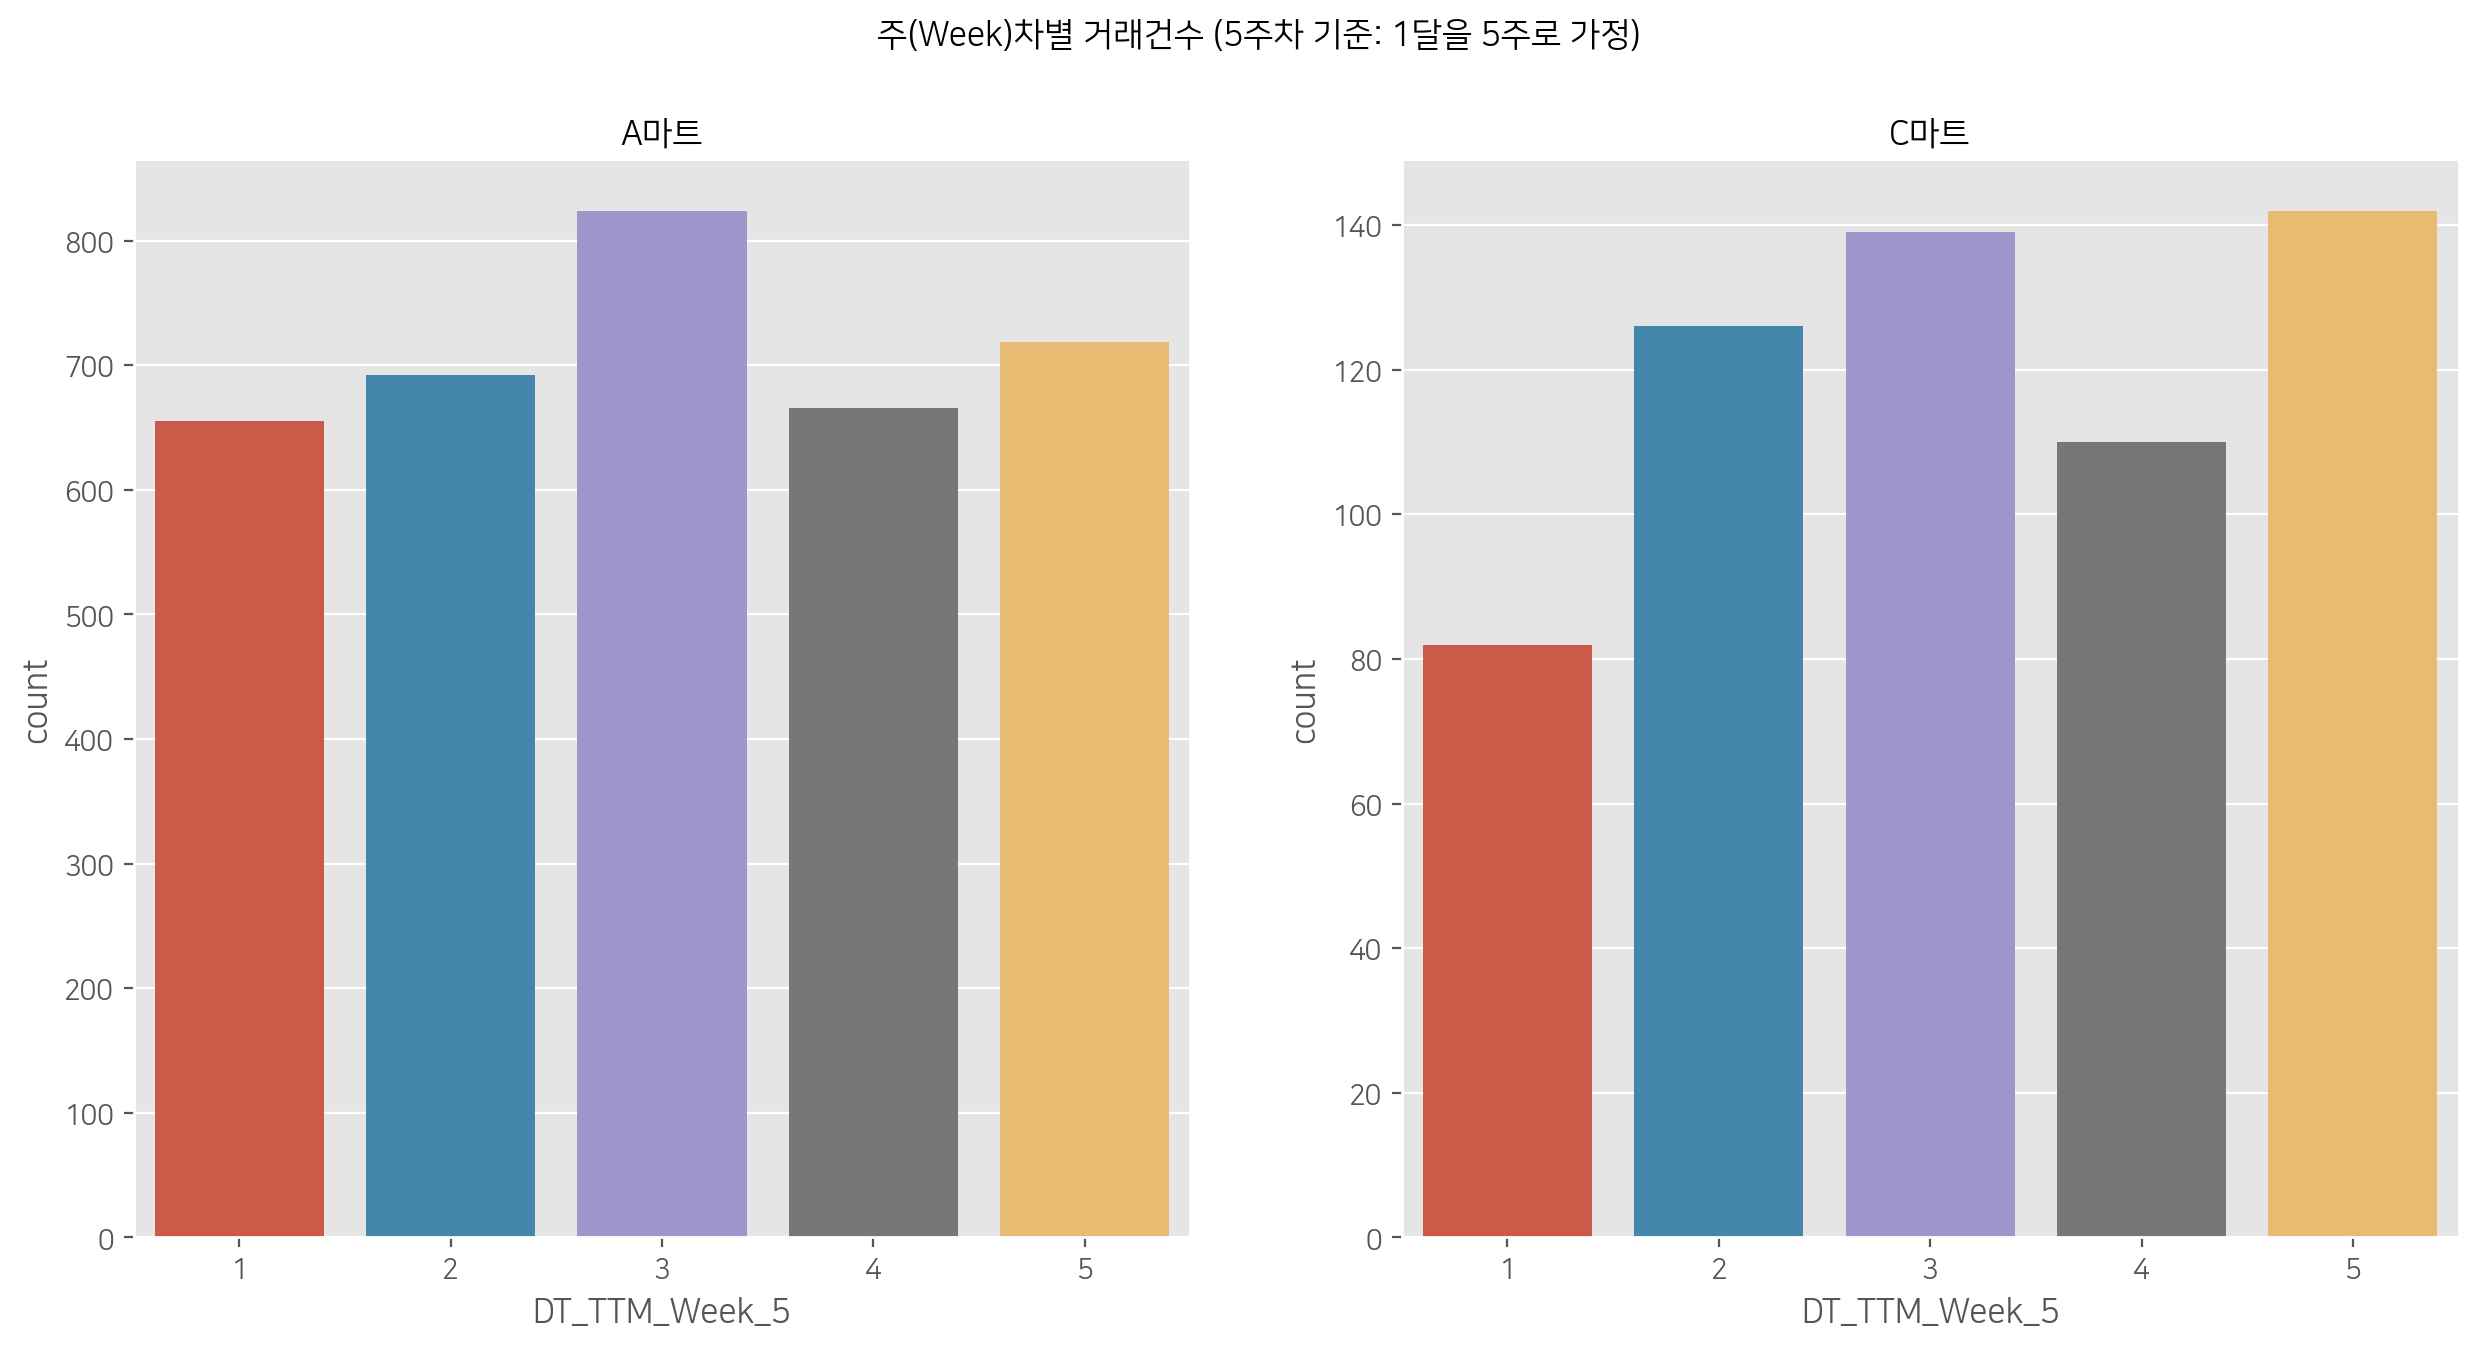

In [7]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')
plt.suptitle('주(Week)차별 거래건수 (5주차 기준: 1달을 5주로 가정)', fontweight='bold', size = 12)

plt.subplot(121)
plt.title('A마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_a['DT_TTM_Week_5'])

plt.subplot(122)
plt.title('C마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_c['DT_TTM_Week_5'])

<AxesSubplot:title={'center':'C마트'}, xlabel='DT_TTM_Month', ylabel='count'>

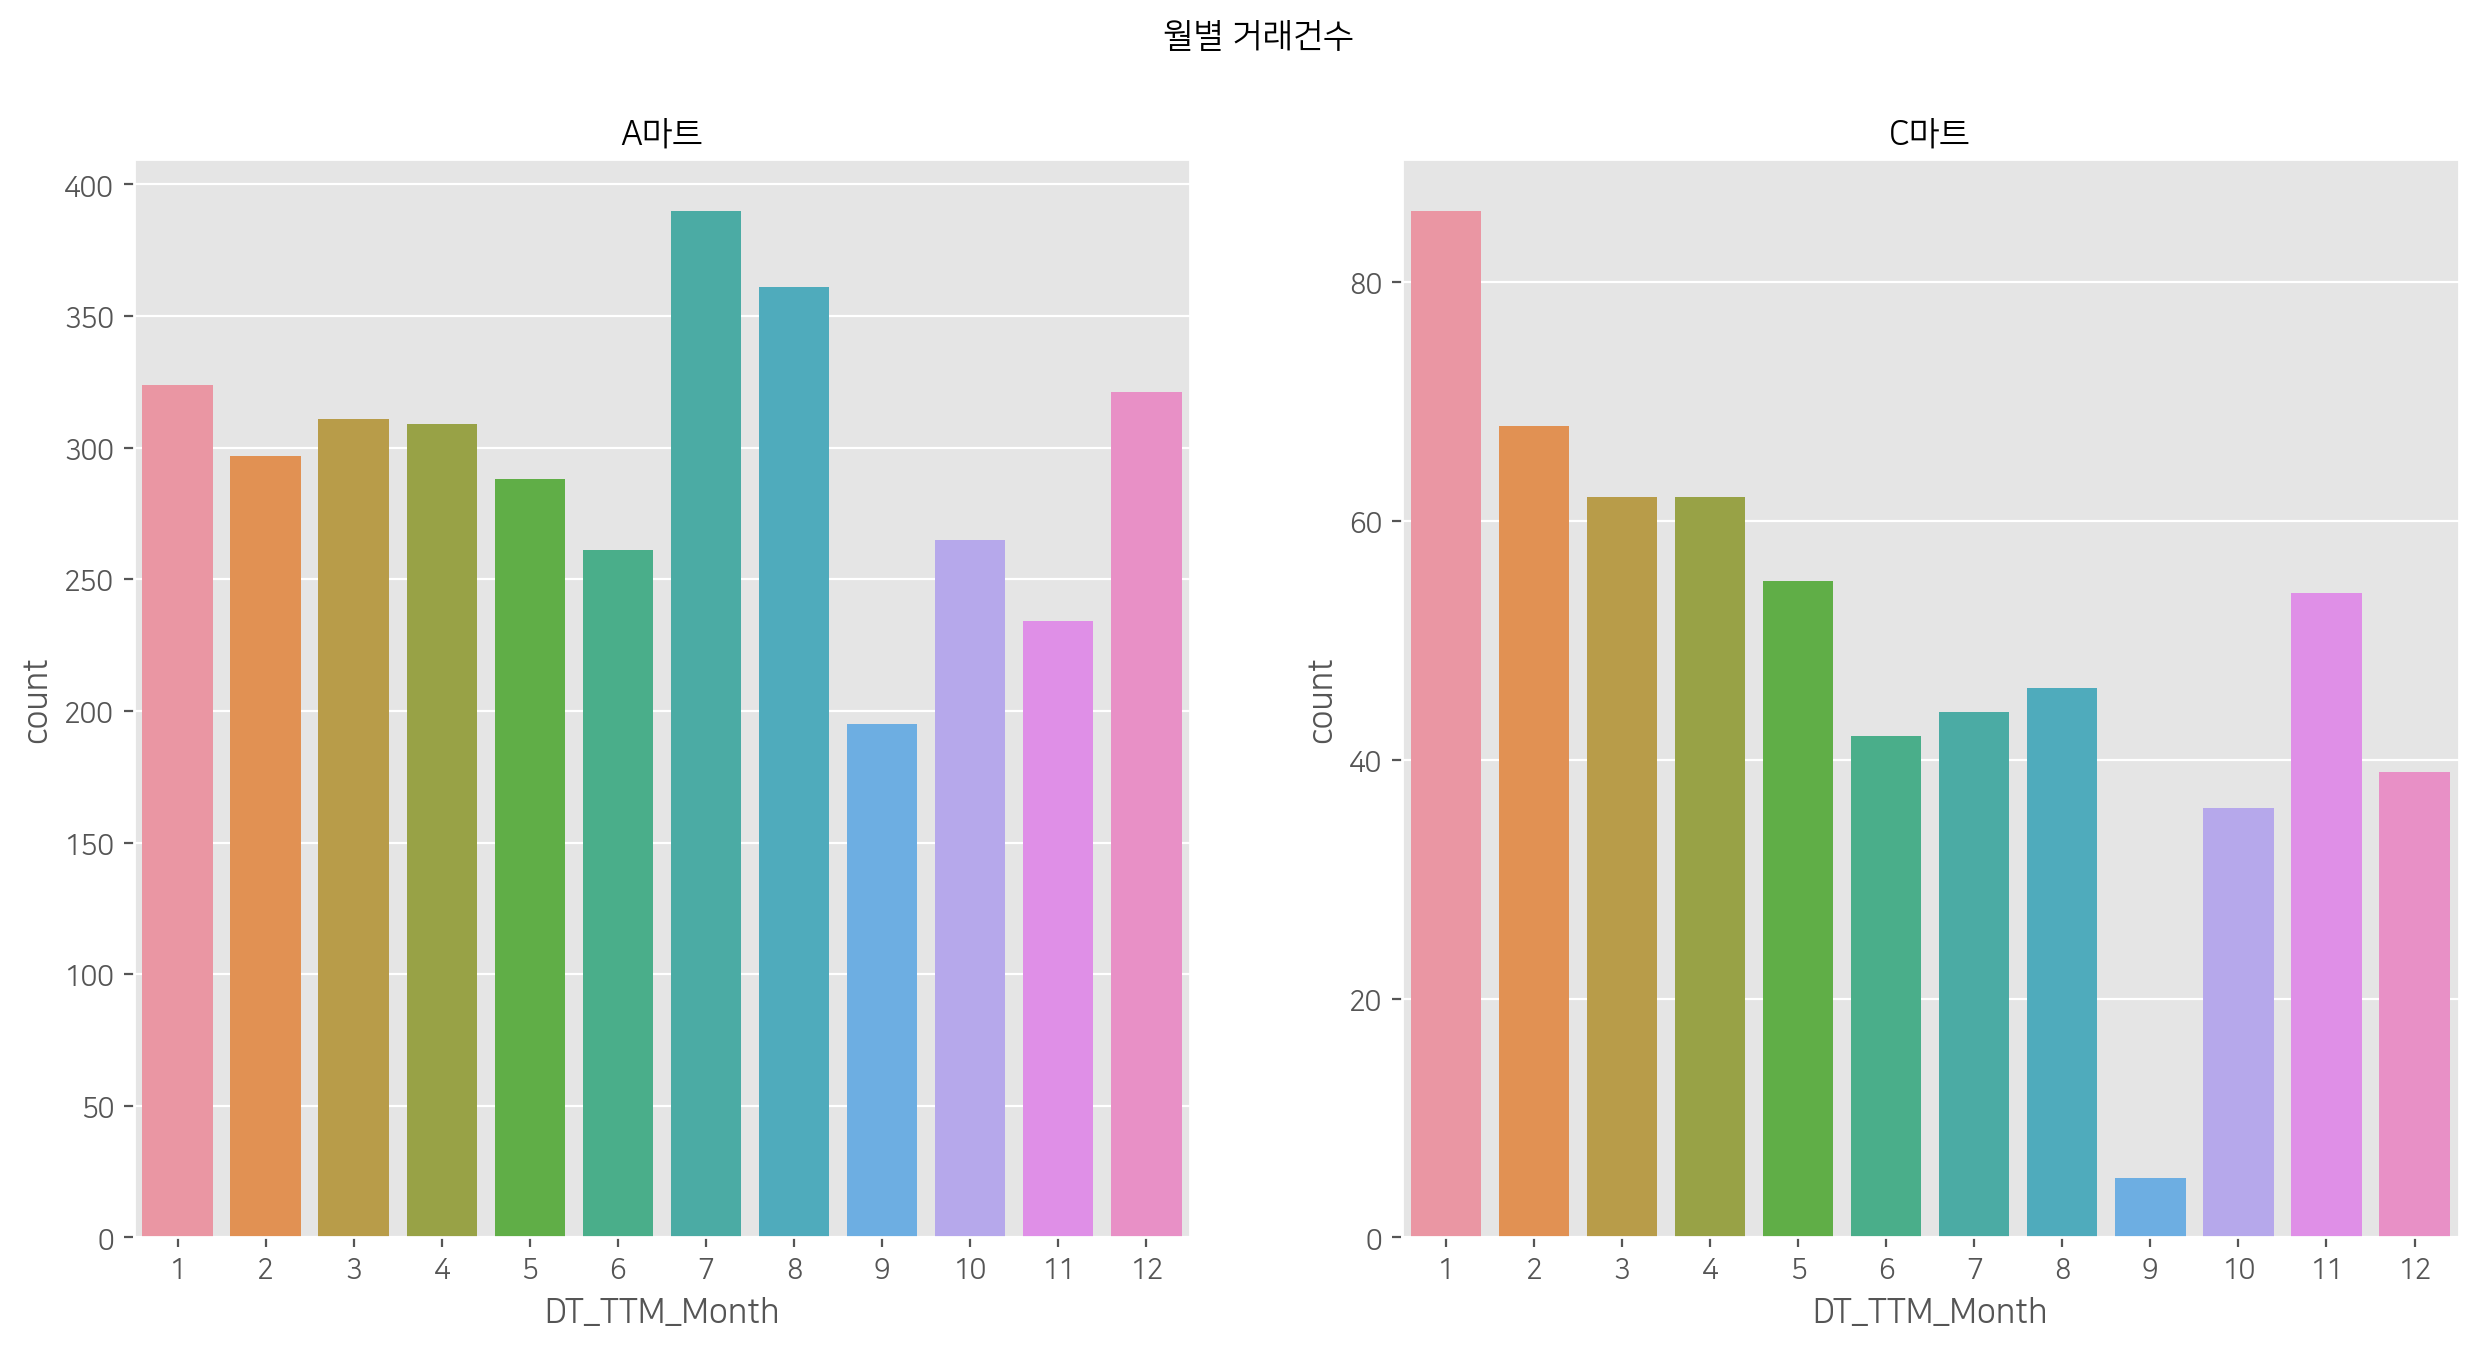

In [8]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')
plt.suptitle('월별 거래건수', fontweight='bold', size = 12)

plt.subplot(121)
plt.title('A마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_a['DT_TTM_Month'])

plt.subplot(122)
plt.title('C마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_c['DT_TTM_Month'])

<AxesSubplot:title={'center':'C마트'}, xlabel='DT_TTM_Day_of_the_Week', ylabel='count'>

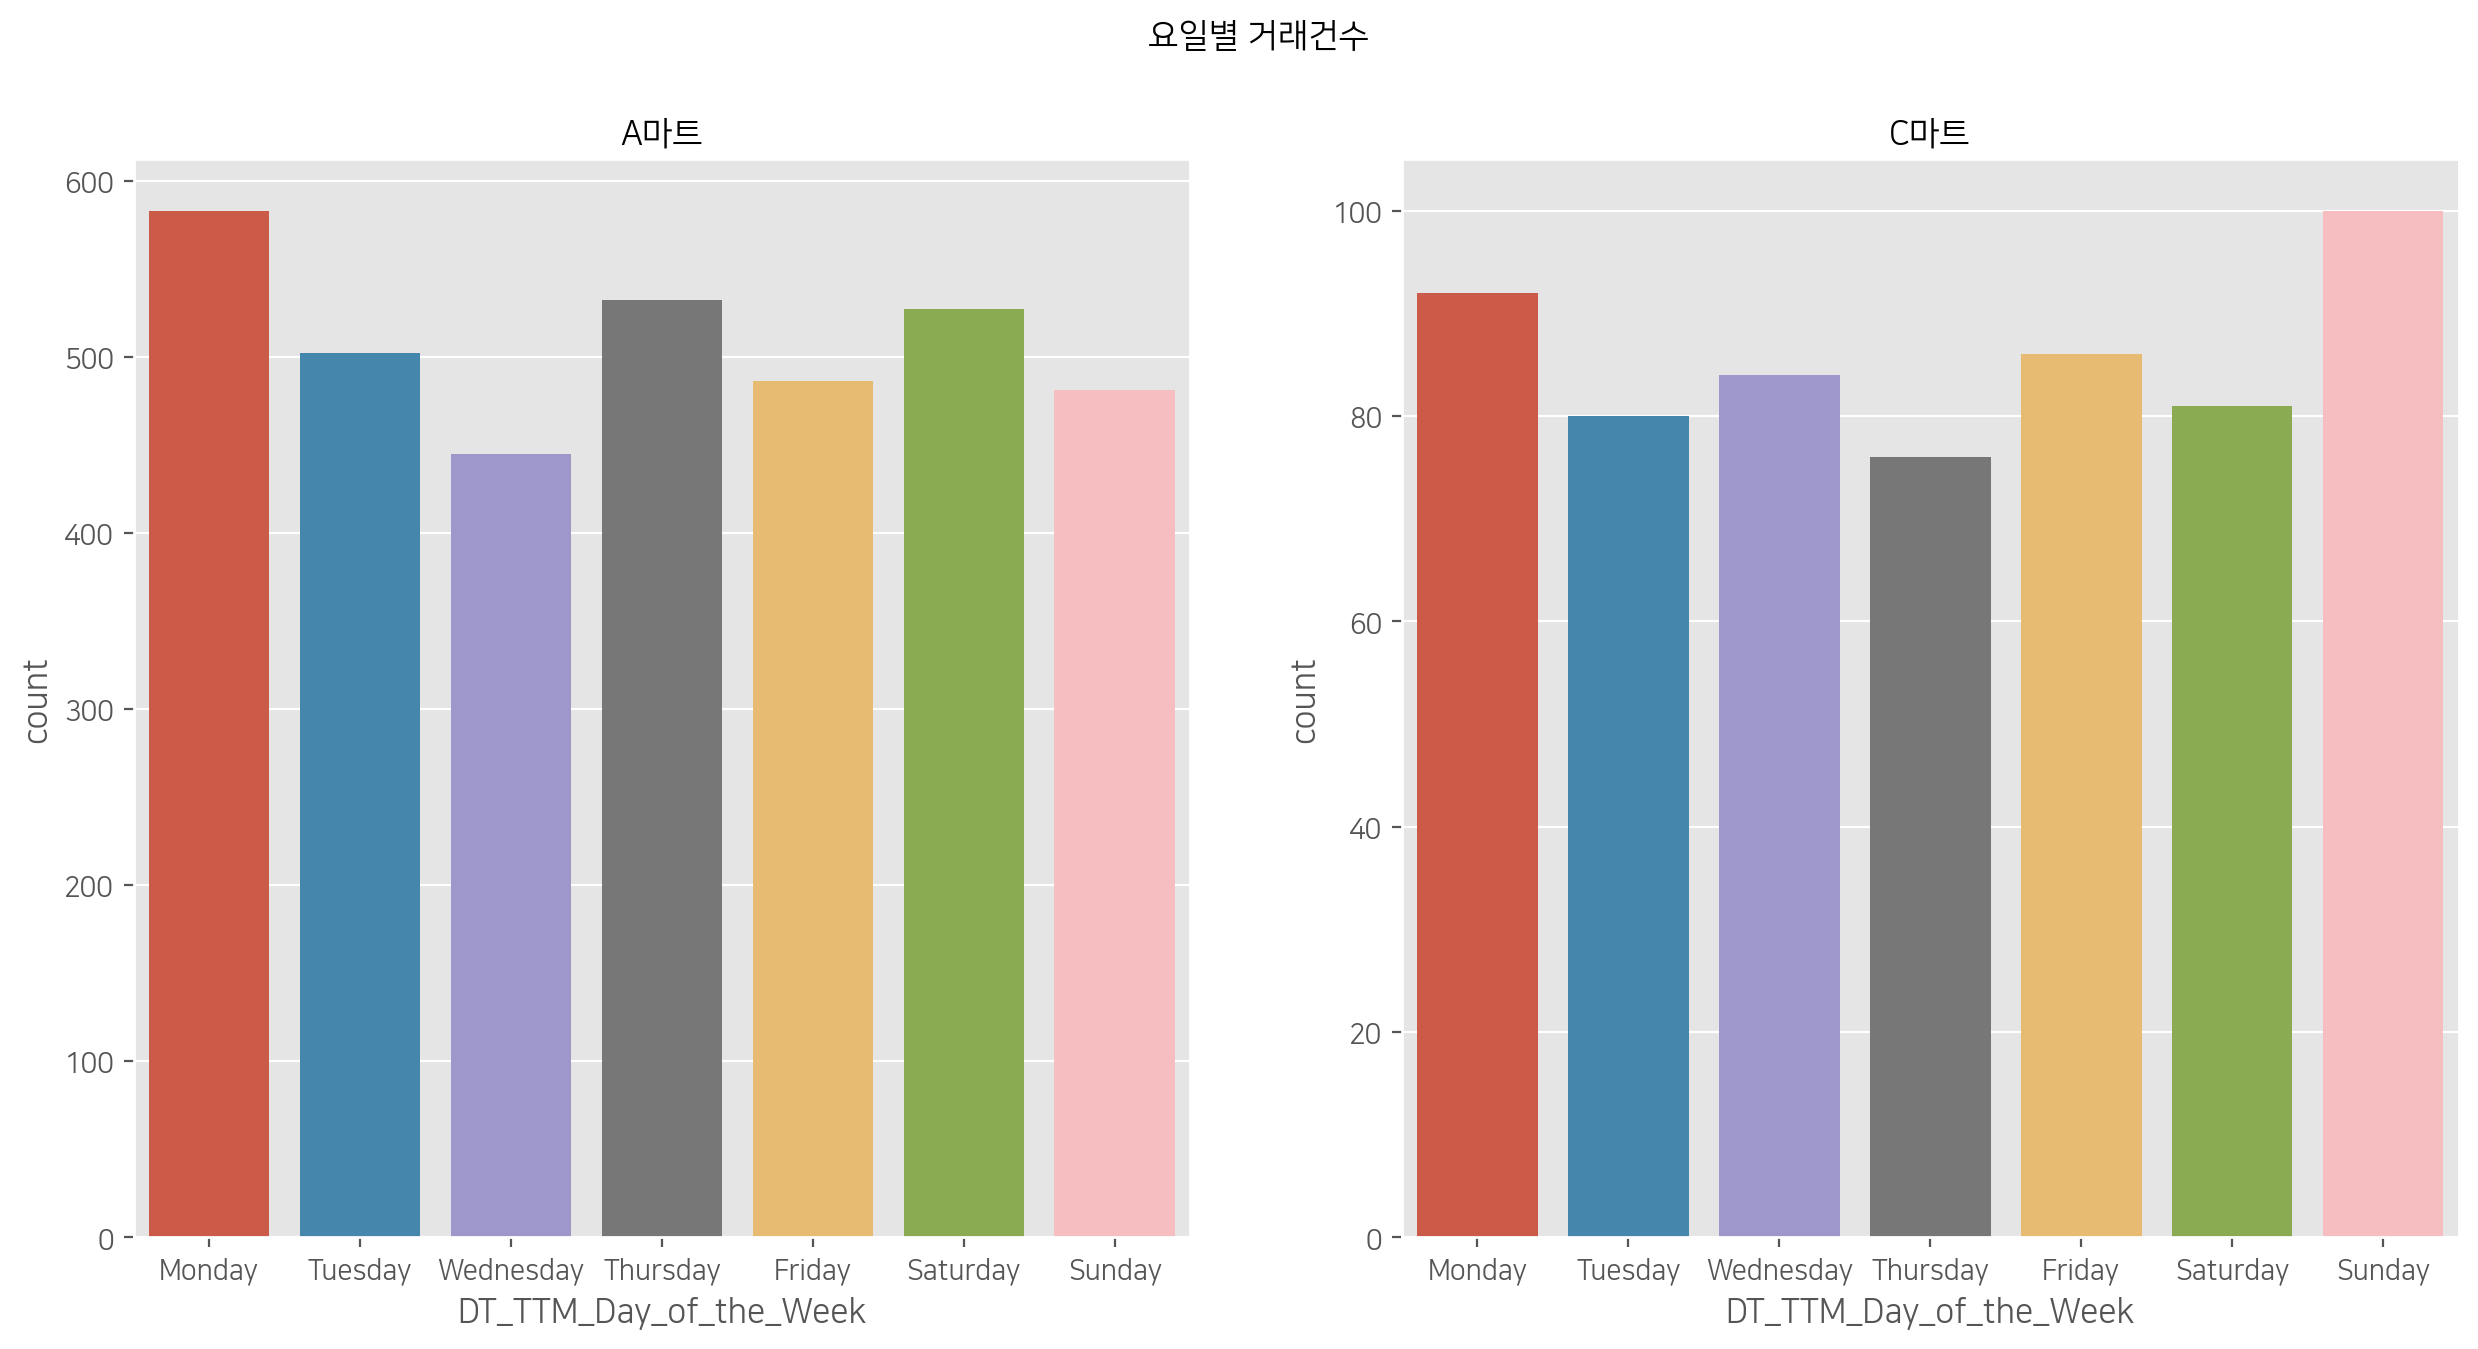

In [9]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')
plt.suptitle('요일별 거래건수', fontweight='bold', size = 12)

plt.subplot(121)
plt.title('A마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_a['DT_TTM_Day_of_the_Week'], order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.subplot(122)
plt.title('C마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_c['DT_TTM_Day_of_the_Week'], order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

<AxesSubplot:title={'center':'C마트'}, xlabel='DT_TTM_Hour', ylabel='count'>

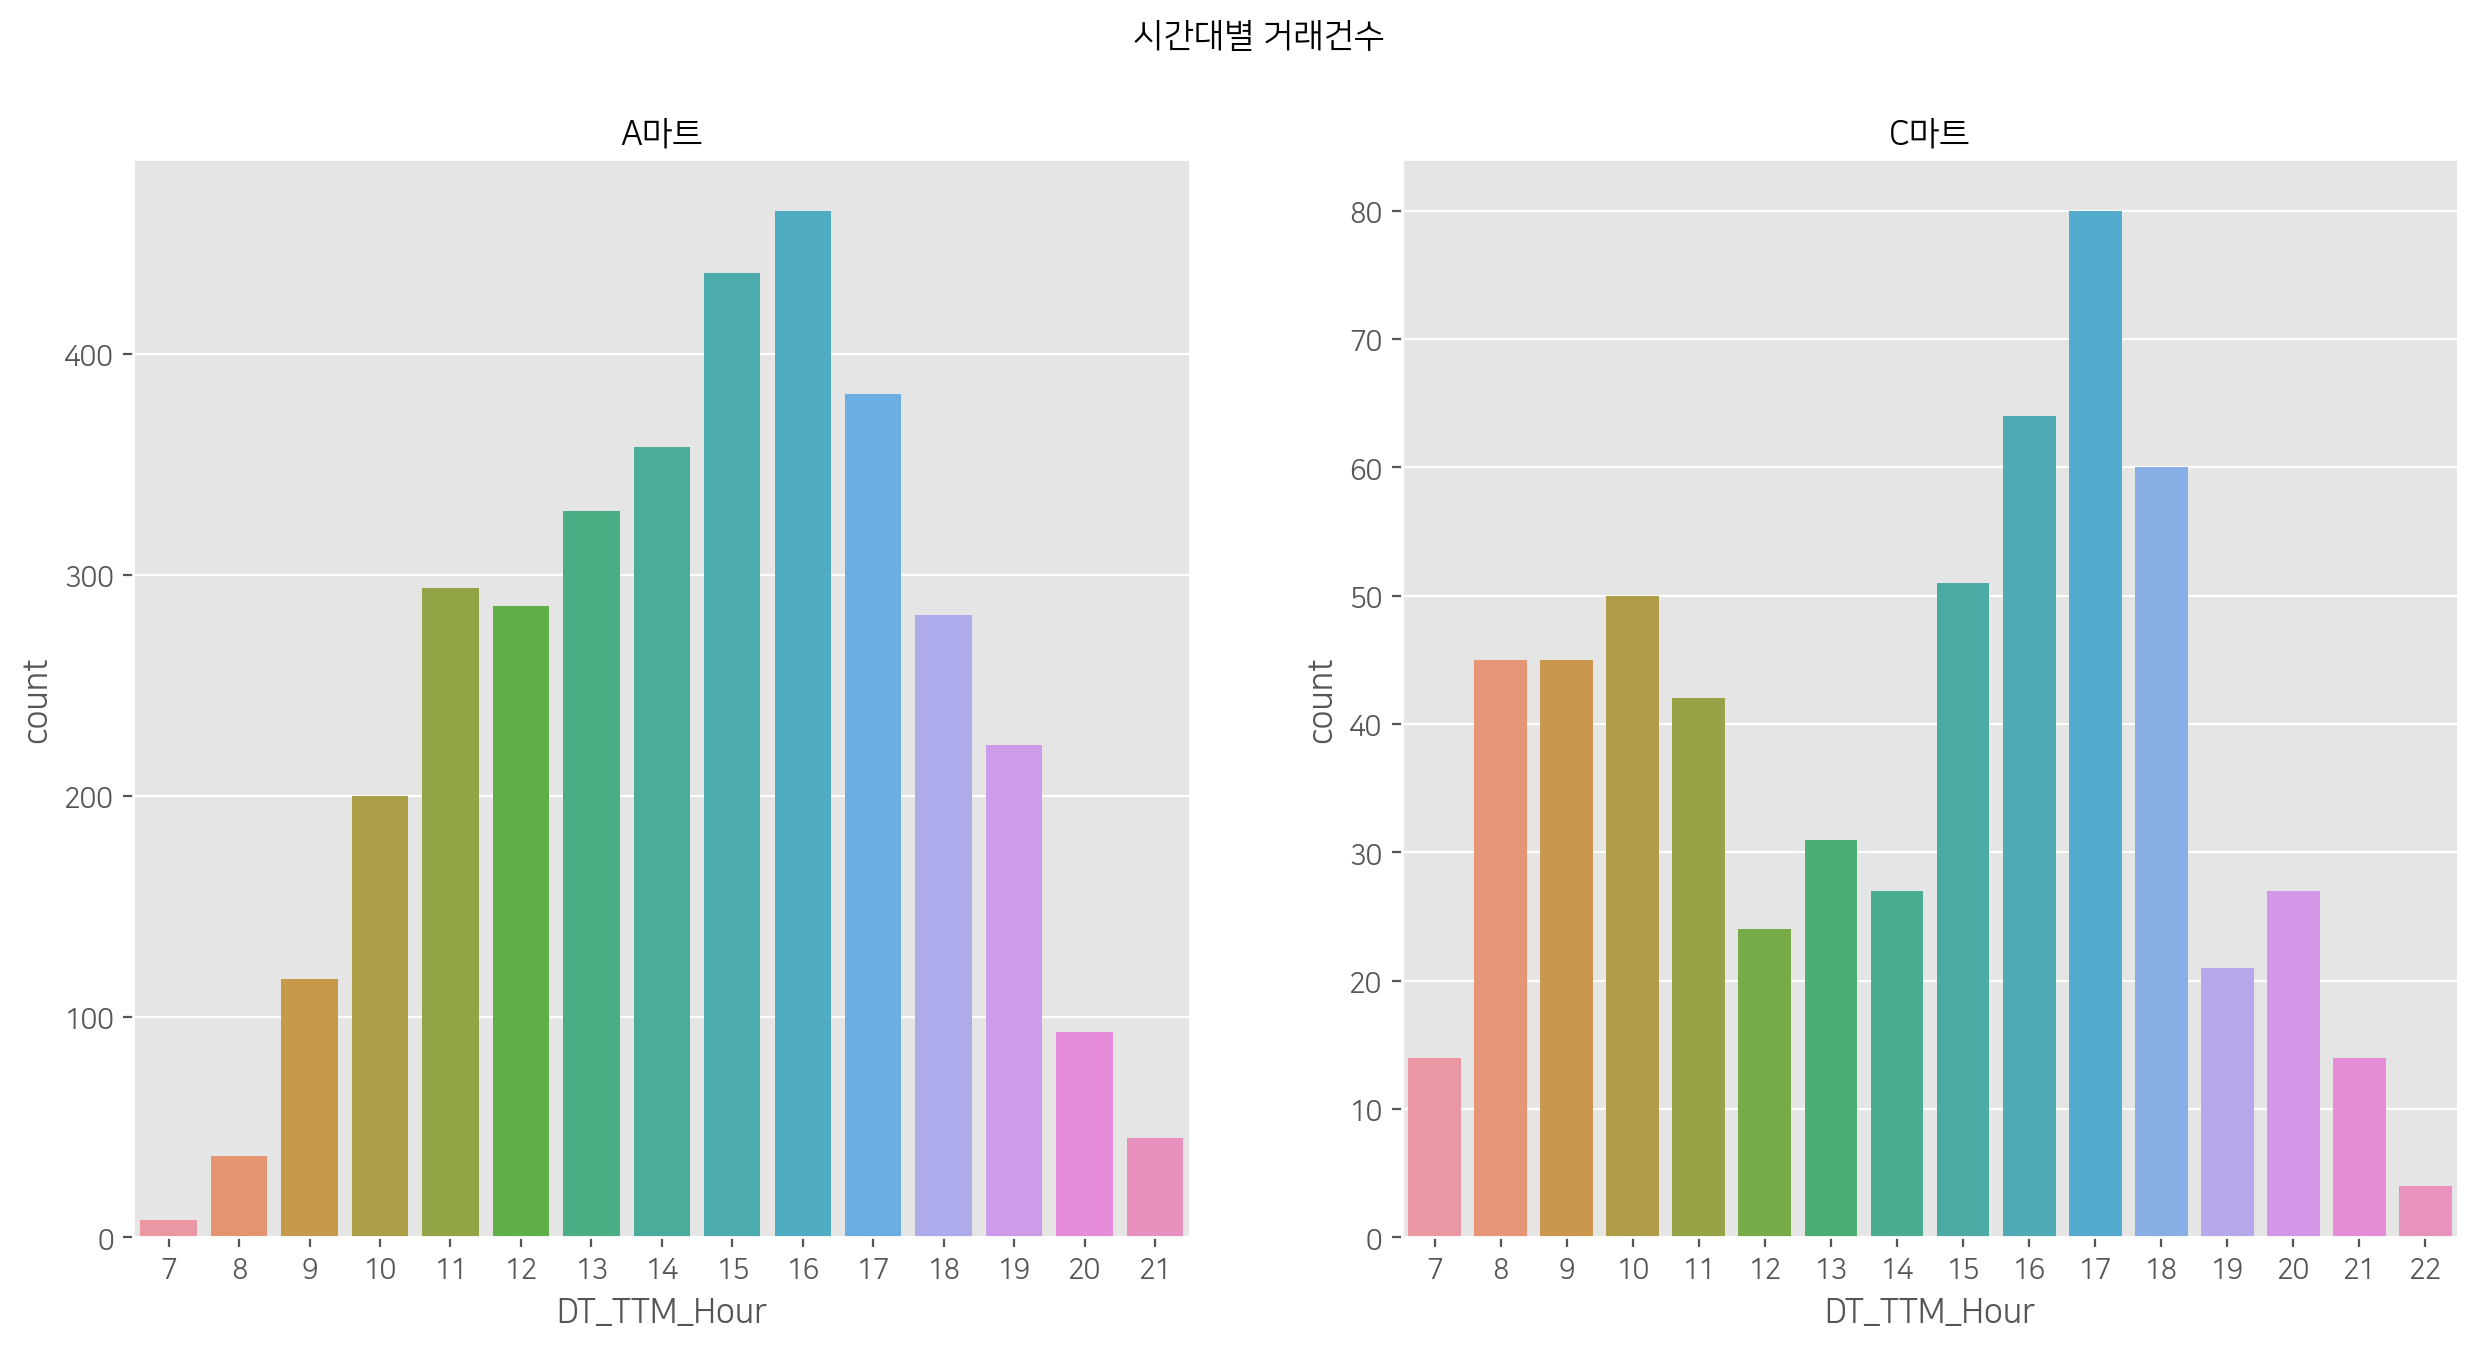

In [10]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')
plt.suptitle('시간대별 거래건수', fontweight='bold', size = 12)

plt.subplot(121)
plt.title('A마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_a['DT_TTM_Hour'])

plt.subplot(122)
plt.title('C마트', fontweight='bold', size = 12)
sns.countplot(x=cnm_c['DT_TTM_Hour'])

<AxesSubplot:title={'center':'C마트 콩나물 일자별 판매량'}, xlabel='REAL_SAL_DT'>

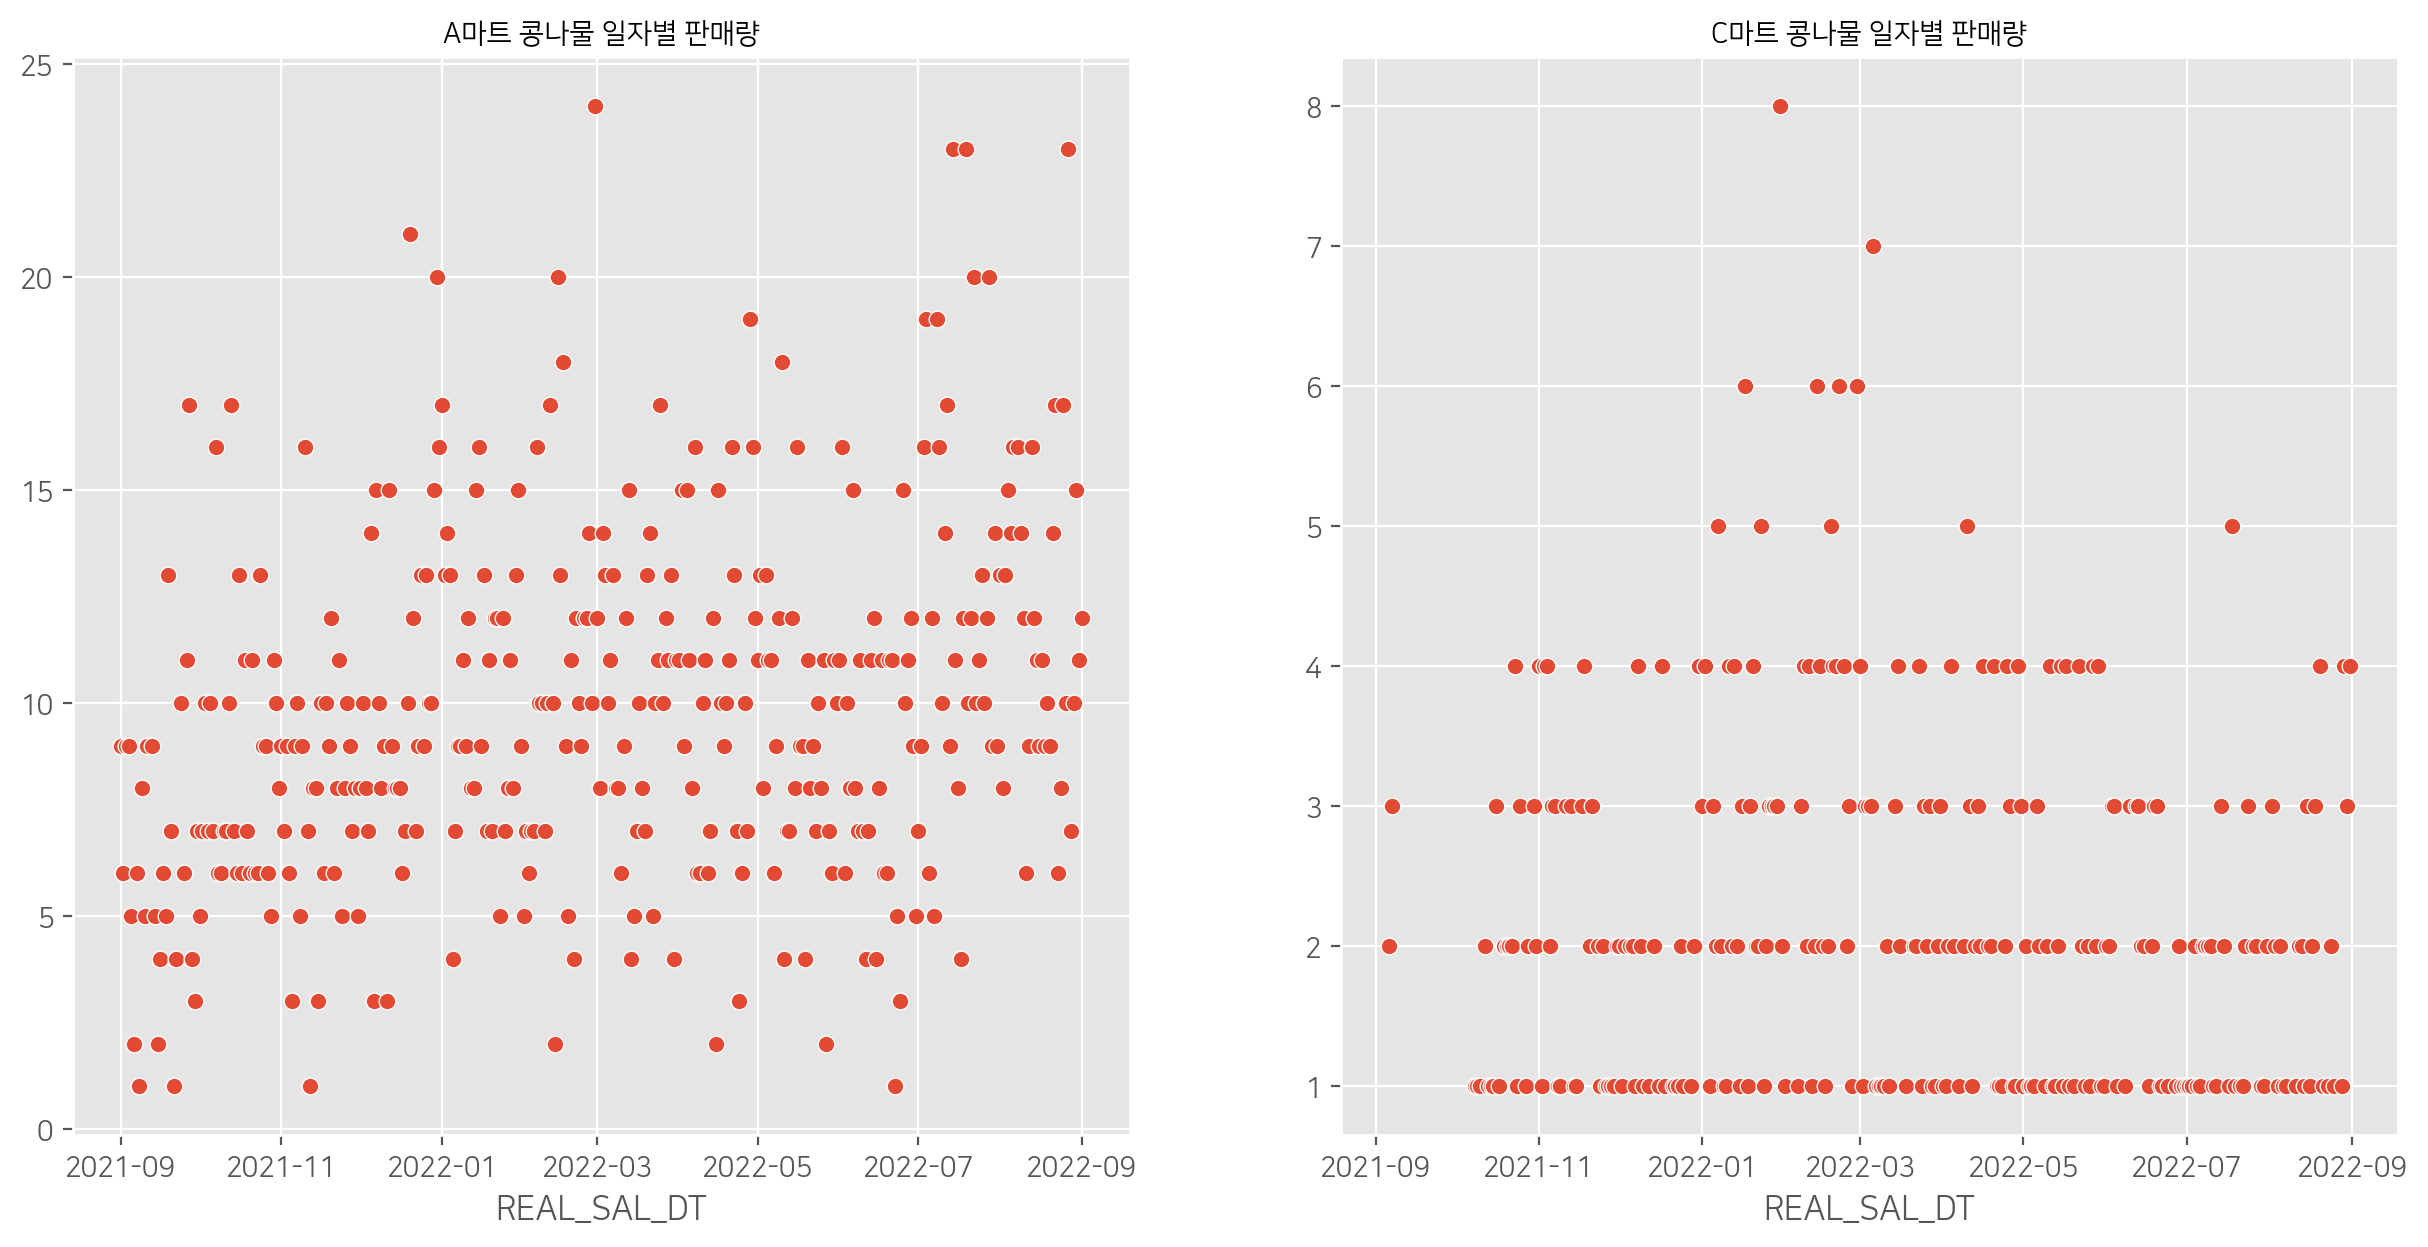

In [11]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

plt.subplot(121)
plt.title('A마트 콩나물 일자별 판매량', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.scatterplot(x=a.index, y=a.values)

plt.subplot(122)
plt.title('C마트 콩나물 일자별 판매량', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.scatterplot(x=c.index, y=c.values)

<AxesSubplot:title={'center':'C마트 콩나물 일자별 총 판매량'}, xlabel='REAL_SAL_DT'>

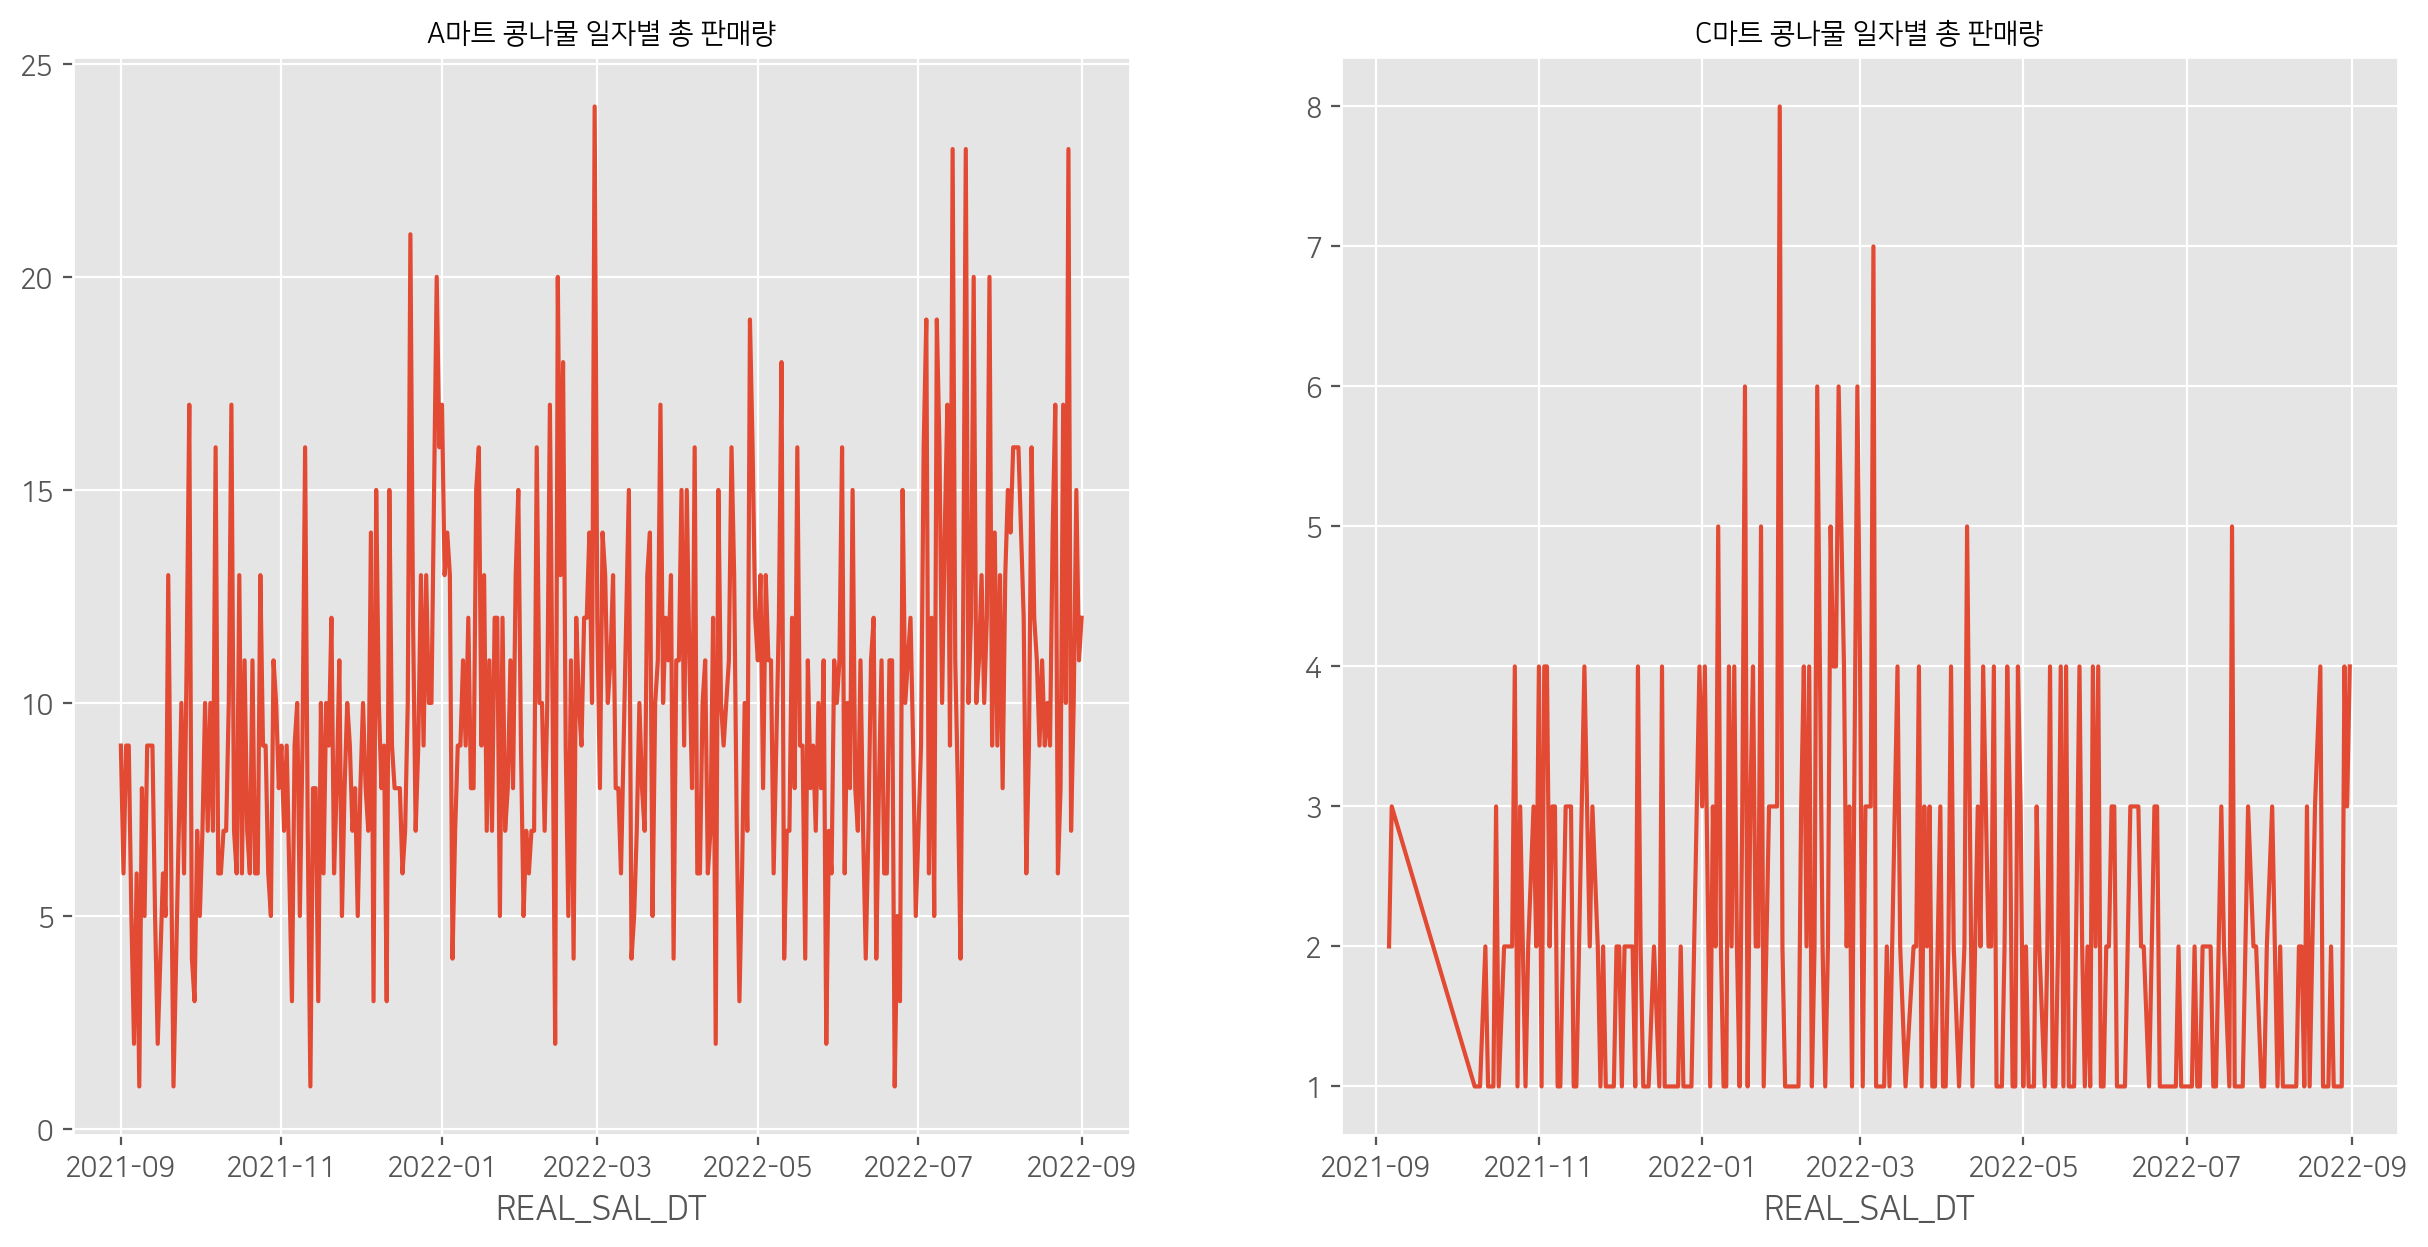

In [12]:
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

plt.subplot(121)
plt.title('A마트 콩나물 일자별 총 판매량', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(x=a.index, y=a.values, estimator=sum) 

plt.subplot(122)
plt.title('C마트 콩나물 일자별 총 판매량', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(x=c.index, y=c.values, estimator=sum)

<AxesSubplot:title={'center':'C마트 콩나물 일자별 평균 구매금액'}, xlabel='REAL_SAL_DT', ylabel='SALE_AMT'>

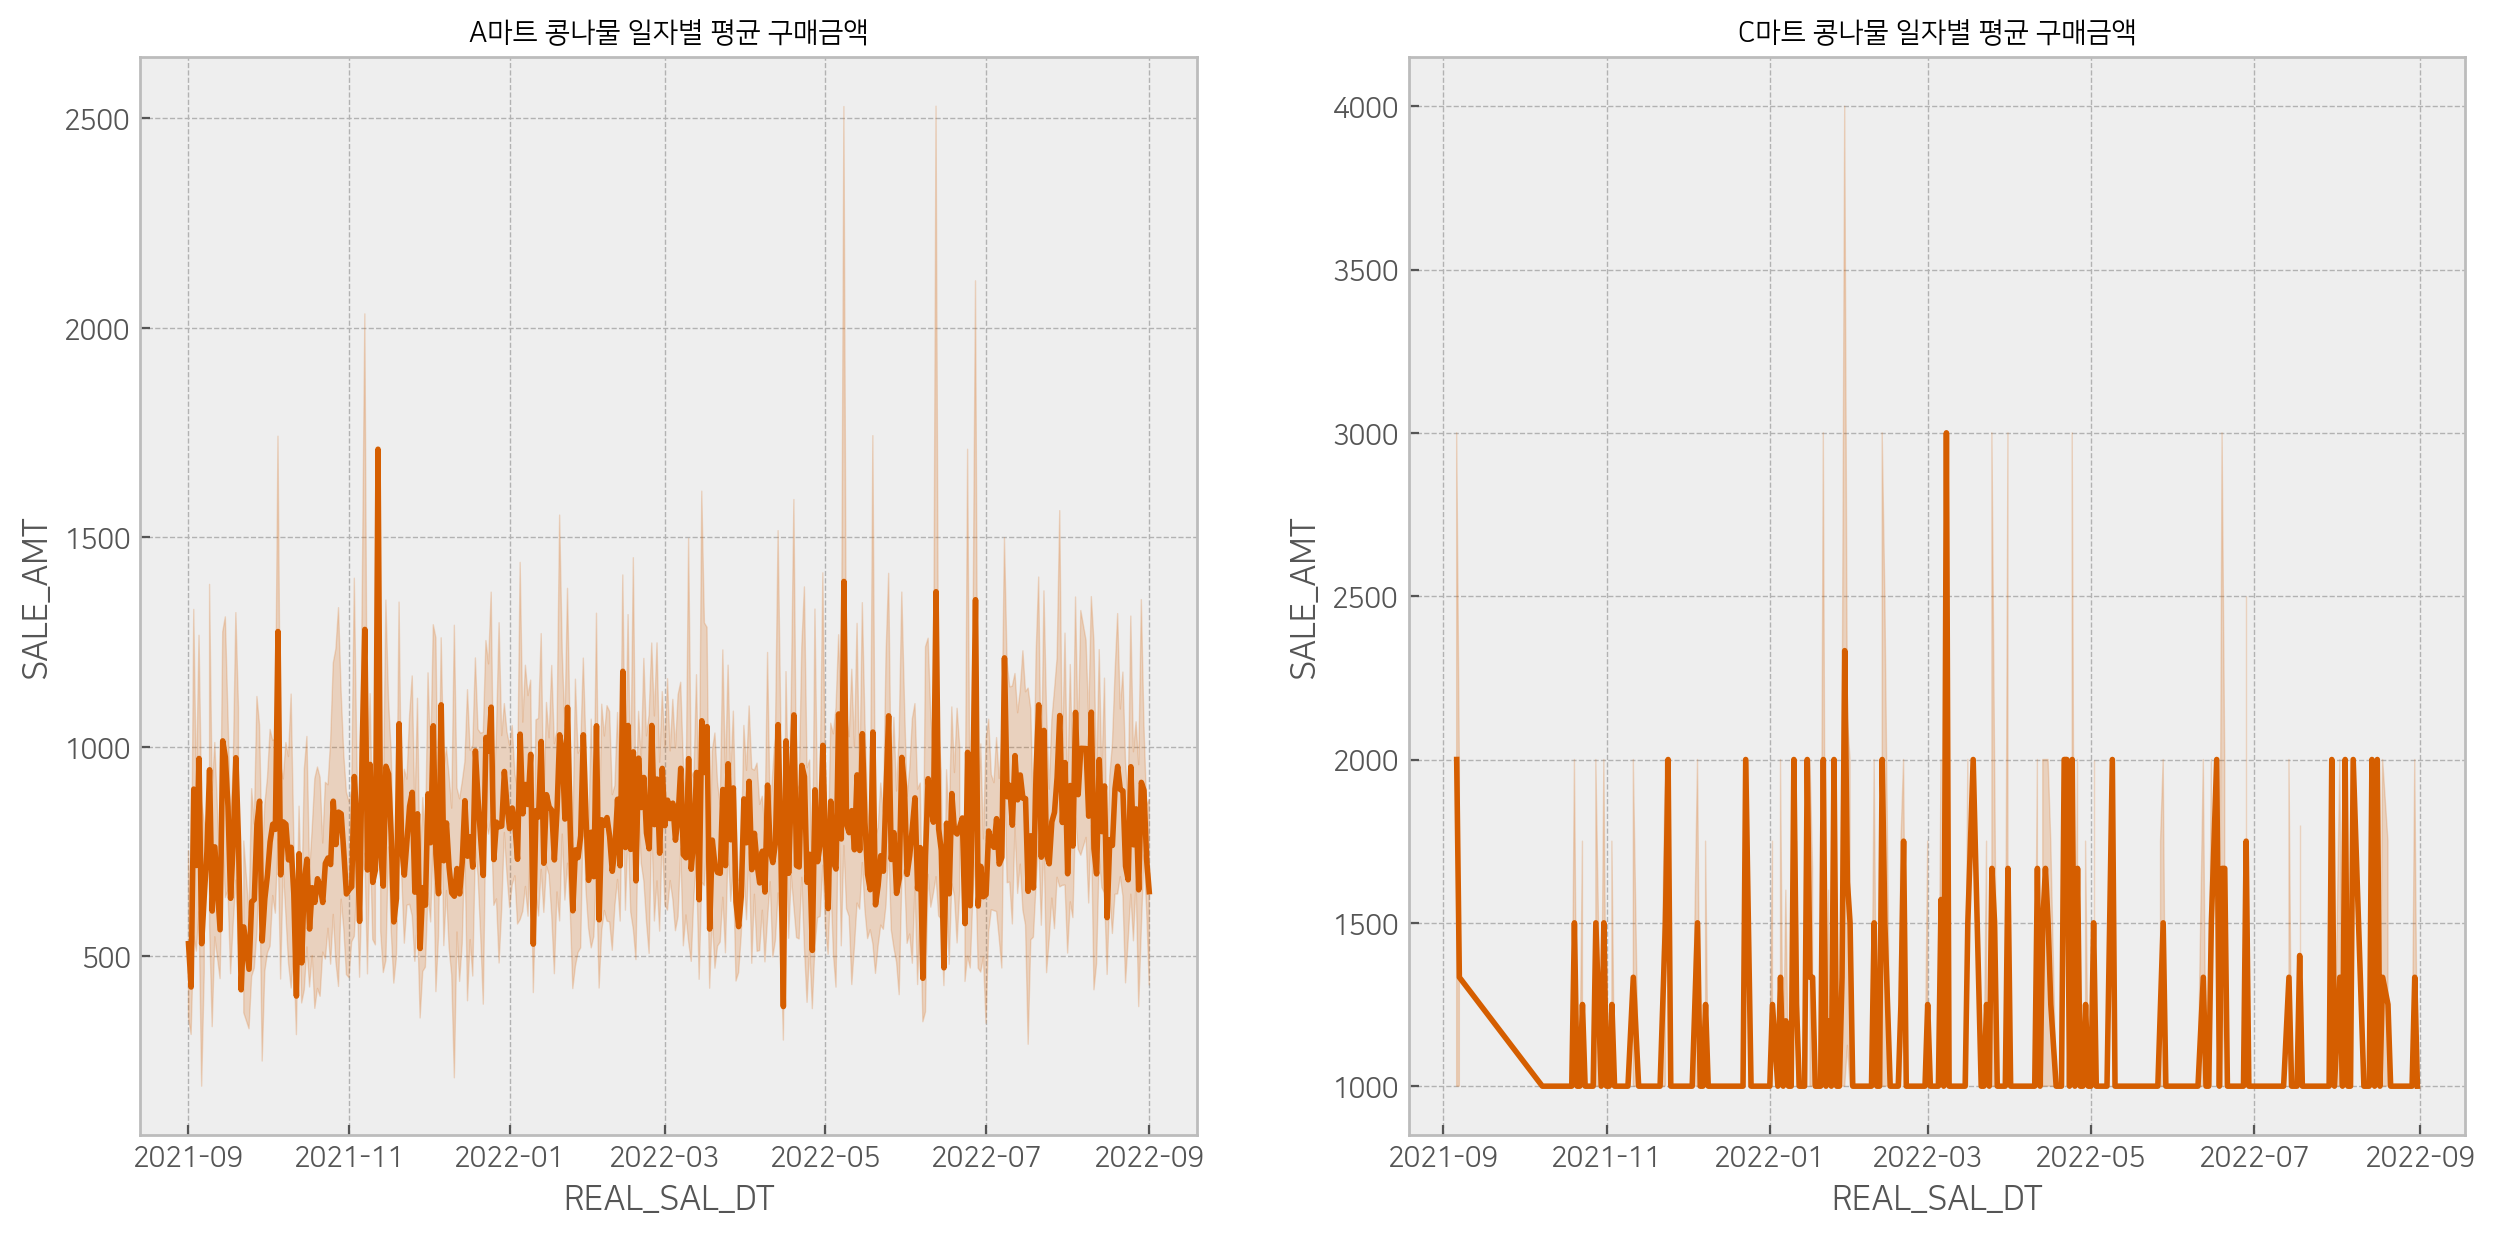

In [13]:
plt.figure(figsize=(15,7))
plt.style.use('bmh')
plt.rcParams['font.family'] = 'NanumSquare' # plt 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨지는 문제 해결

plt.subplot(121)
plt.title('A마트 콩나물 일자별 평균 구매금액', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_a, x='REAL_SAL_DT', y='SALE_AMT', color='C4') # 일자별 구매금액의 평균이 계산됨

plt.subplot(122)
plt.title('C마트 콩나물 일자별 평균 구매금액', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_c, x='REAL_SAL_DT', y='SALE_AMT', color='C4') # 일자별 구매금액의 평균이 계산됨

<AxesSubplot:title={'center':'C마트 콩나물 일시별 평균 구매금액'}, xlabel='DT_TTM', ylabel='SALE_AMT'>

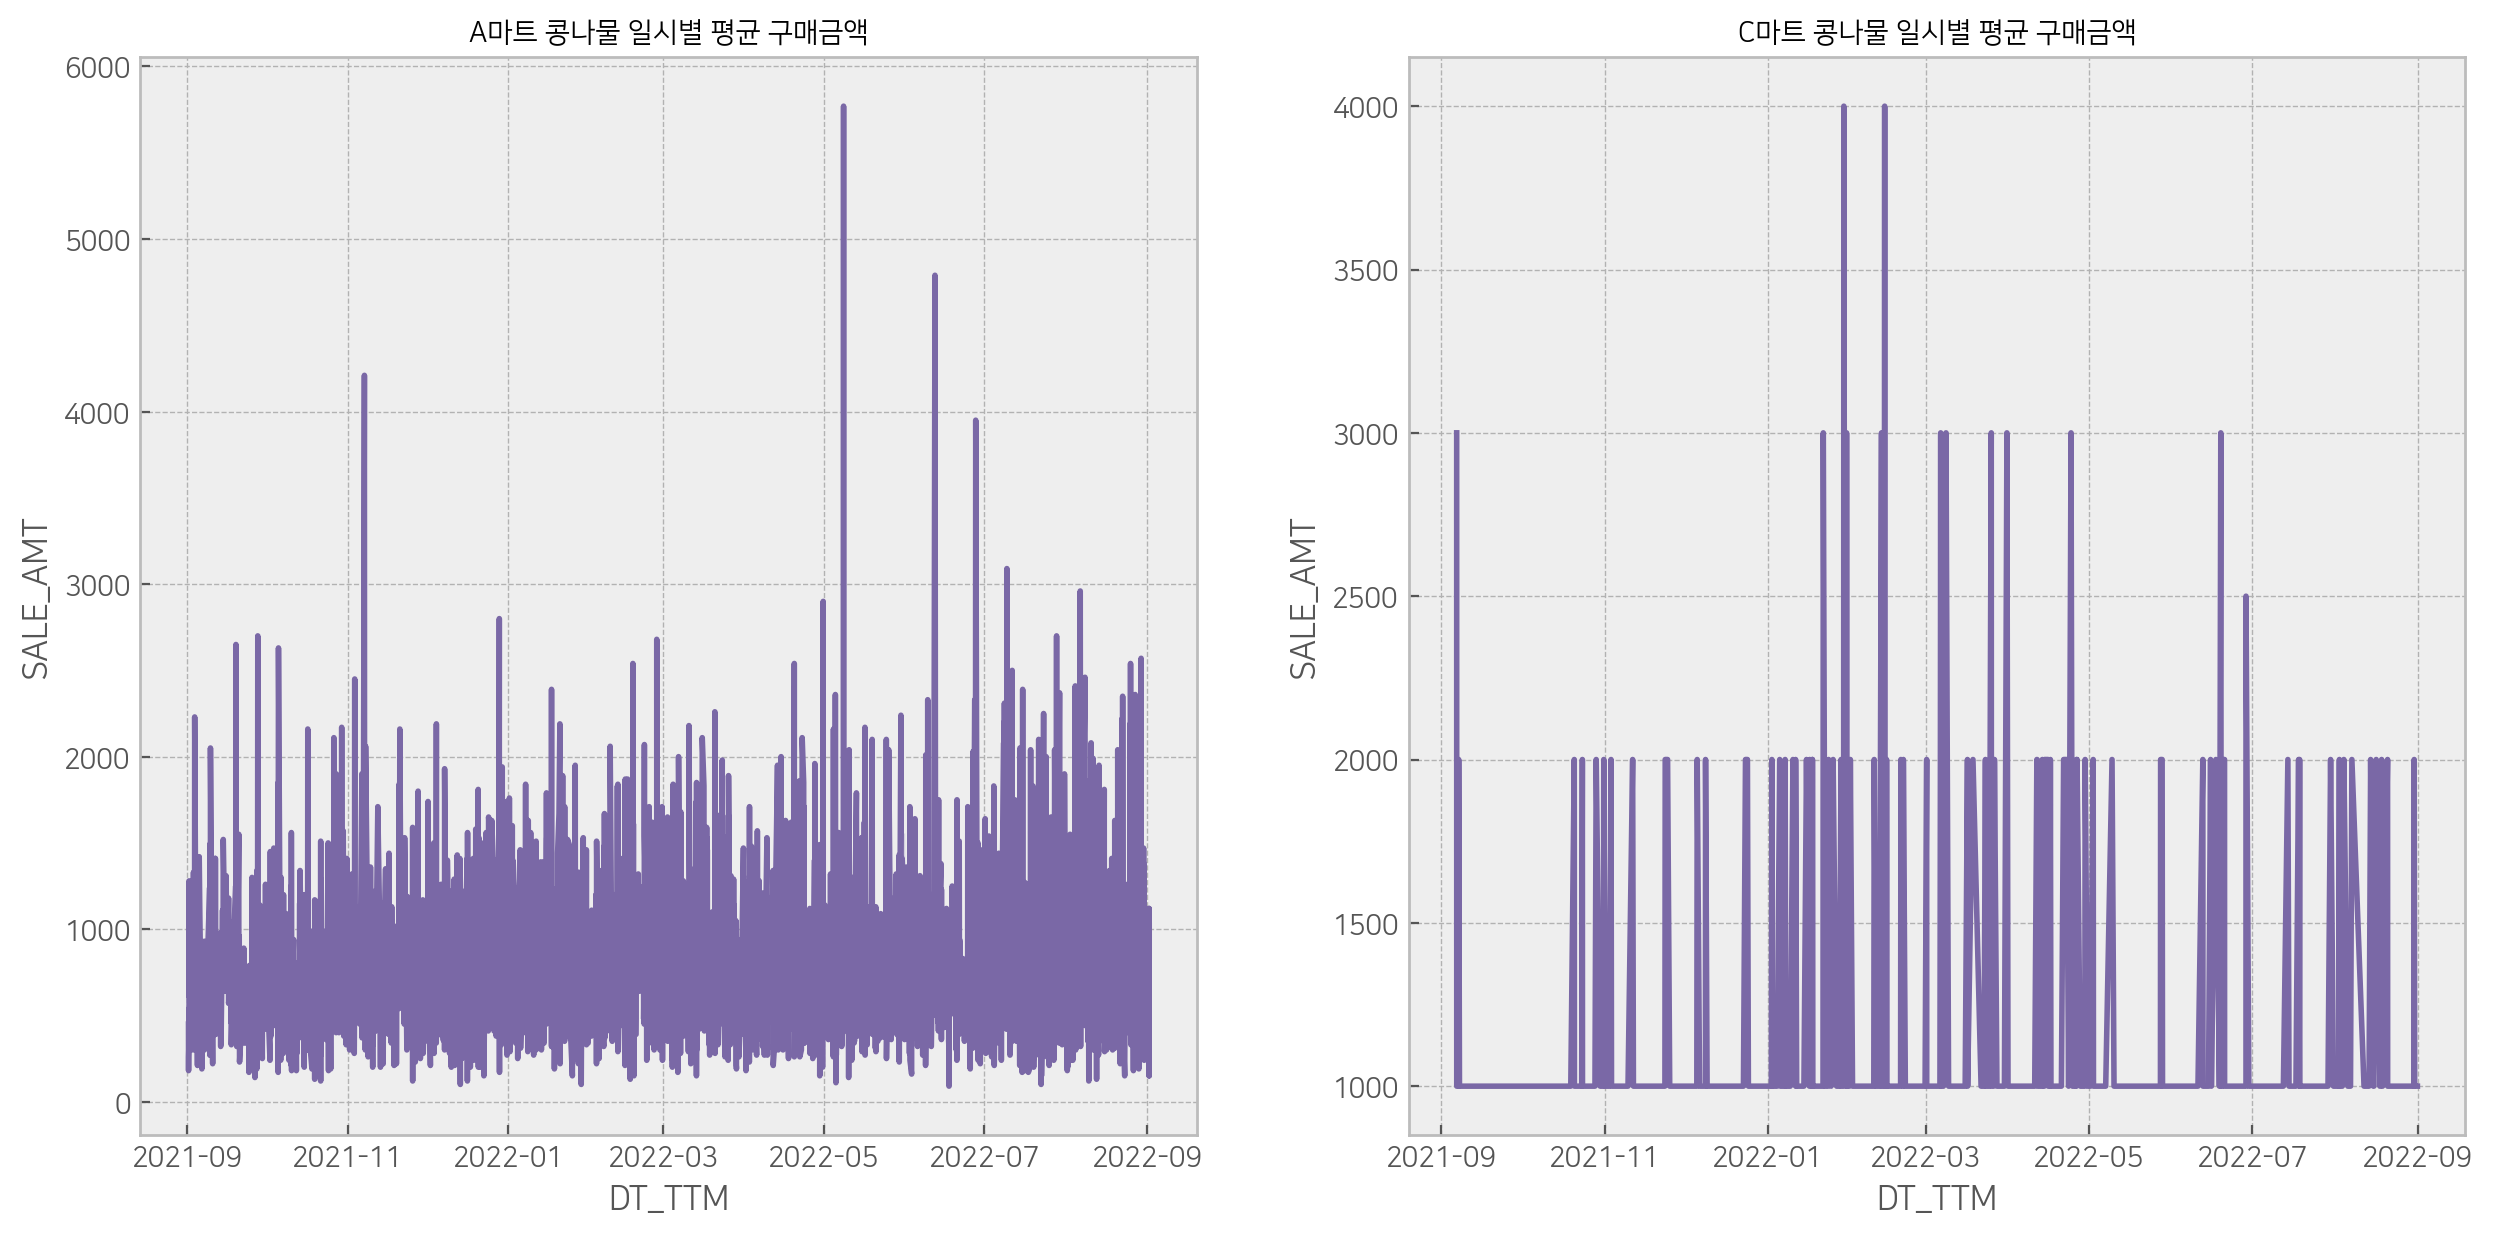

In [14]:
plt.figure(figsize=(15,7))
plt.style.use('bmh')
plt.rcParams['font.family'] = 'NanumSquare' # plt 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨지는 문제 해결

plt.subplot(121)
plt.title('A마트 콩나물 일시별 평균 구매금액', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_a, x='DT_TTM', y='SALE_AMT', color='C2') # 일시별 구매금액의 평균이 계산됨

plt.subplot(122)
plt.title('C마트 콩나물 일시별 평균 구매금액', fontweight='bold', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_c, x='DT_TTM', y='SALE_AMT', color='C2') # 일시별 구매금액의 평균이 계산됨

<AxesSubplot:title={'center':'C마트 콩나물 일자별 구매금액의 합'}, xlabel='REAL_SAL_DT', ylabel='SALE_AMT'>

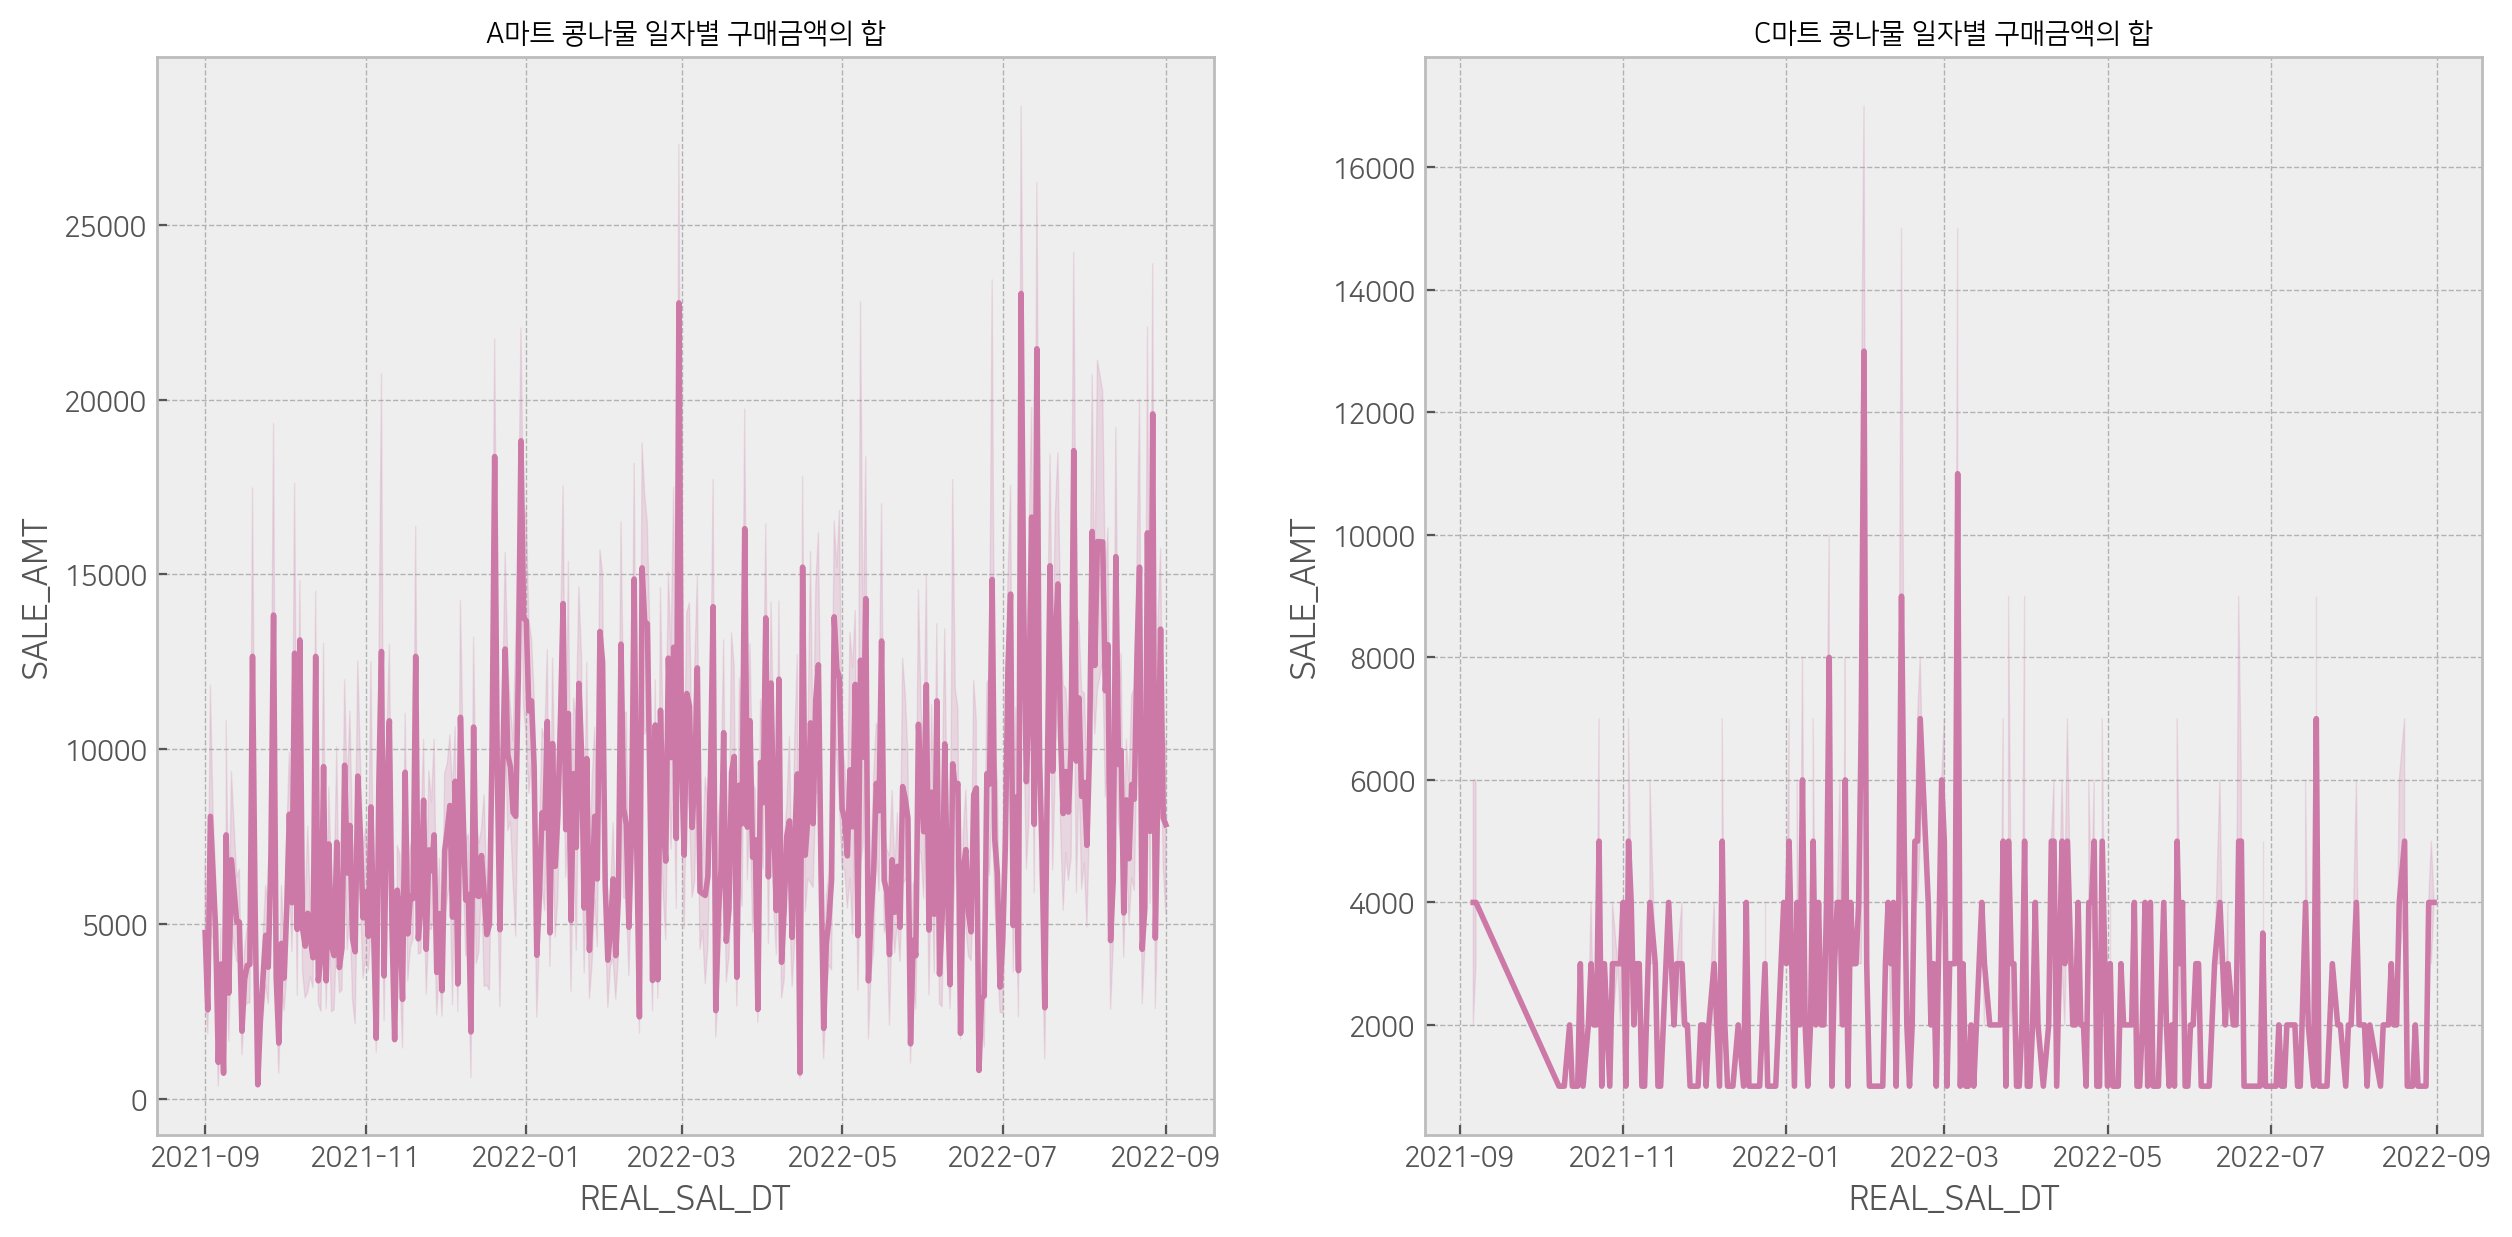

In [15]:
plt.figure(figsize=(15,7))
plt.style.use('bmh')
plt.rcParams['font.family'] = 'NanumSquare' # plt 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨지는 문제 해결

plt.subplot(121)
plt.title('A마트 콩나물 일자별 구매금액의 합', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_a, x='REAL_SAL_DT', y='SALE_AMT', estimator=sum, color='C5') # 일자별 구매금액의 합이 계산됨

plt.subplot(122)
plt.title('C마트 콩나물 일자별 구매금액의 합', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_c, x='REAL_SAL_DT', y='SALE_AMT', estimator=sum, color='C5') # 일자별 구매금액의 합이 계산됨

<AxesSubplot:title={'center':'C마트 콩나물 일시별 구매금액의 합'}, xlabel='DT_TTM', ylabel='SALE_AMT'>

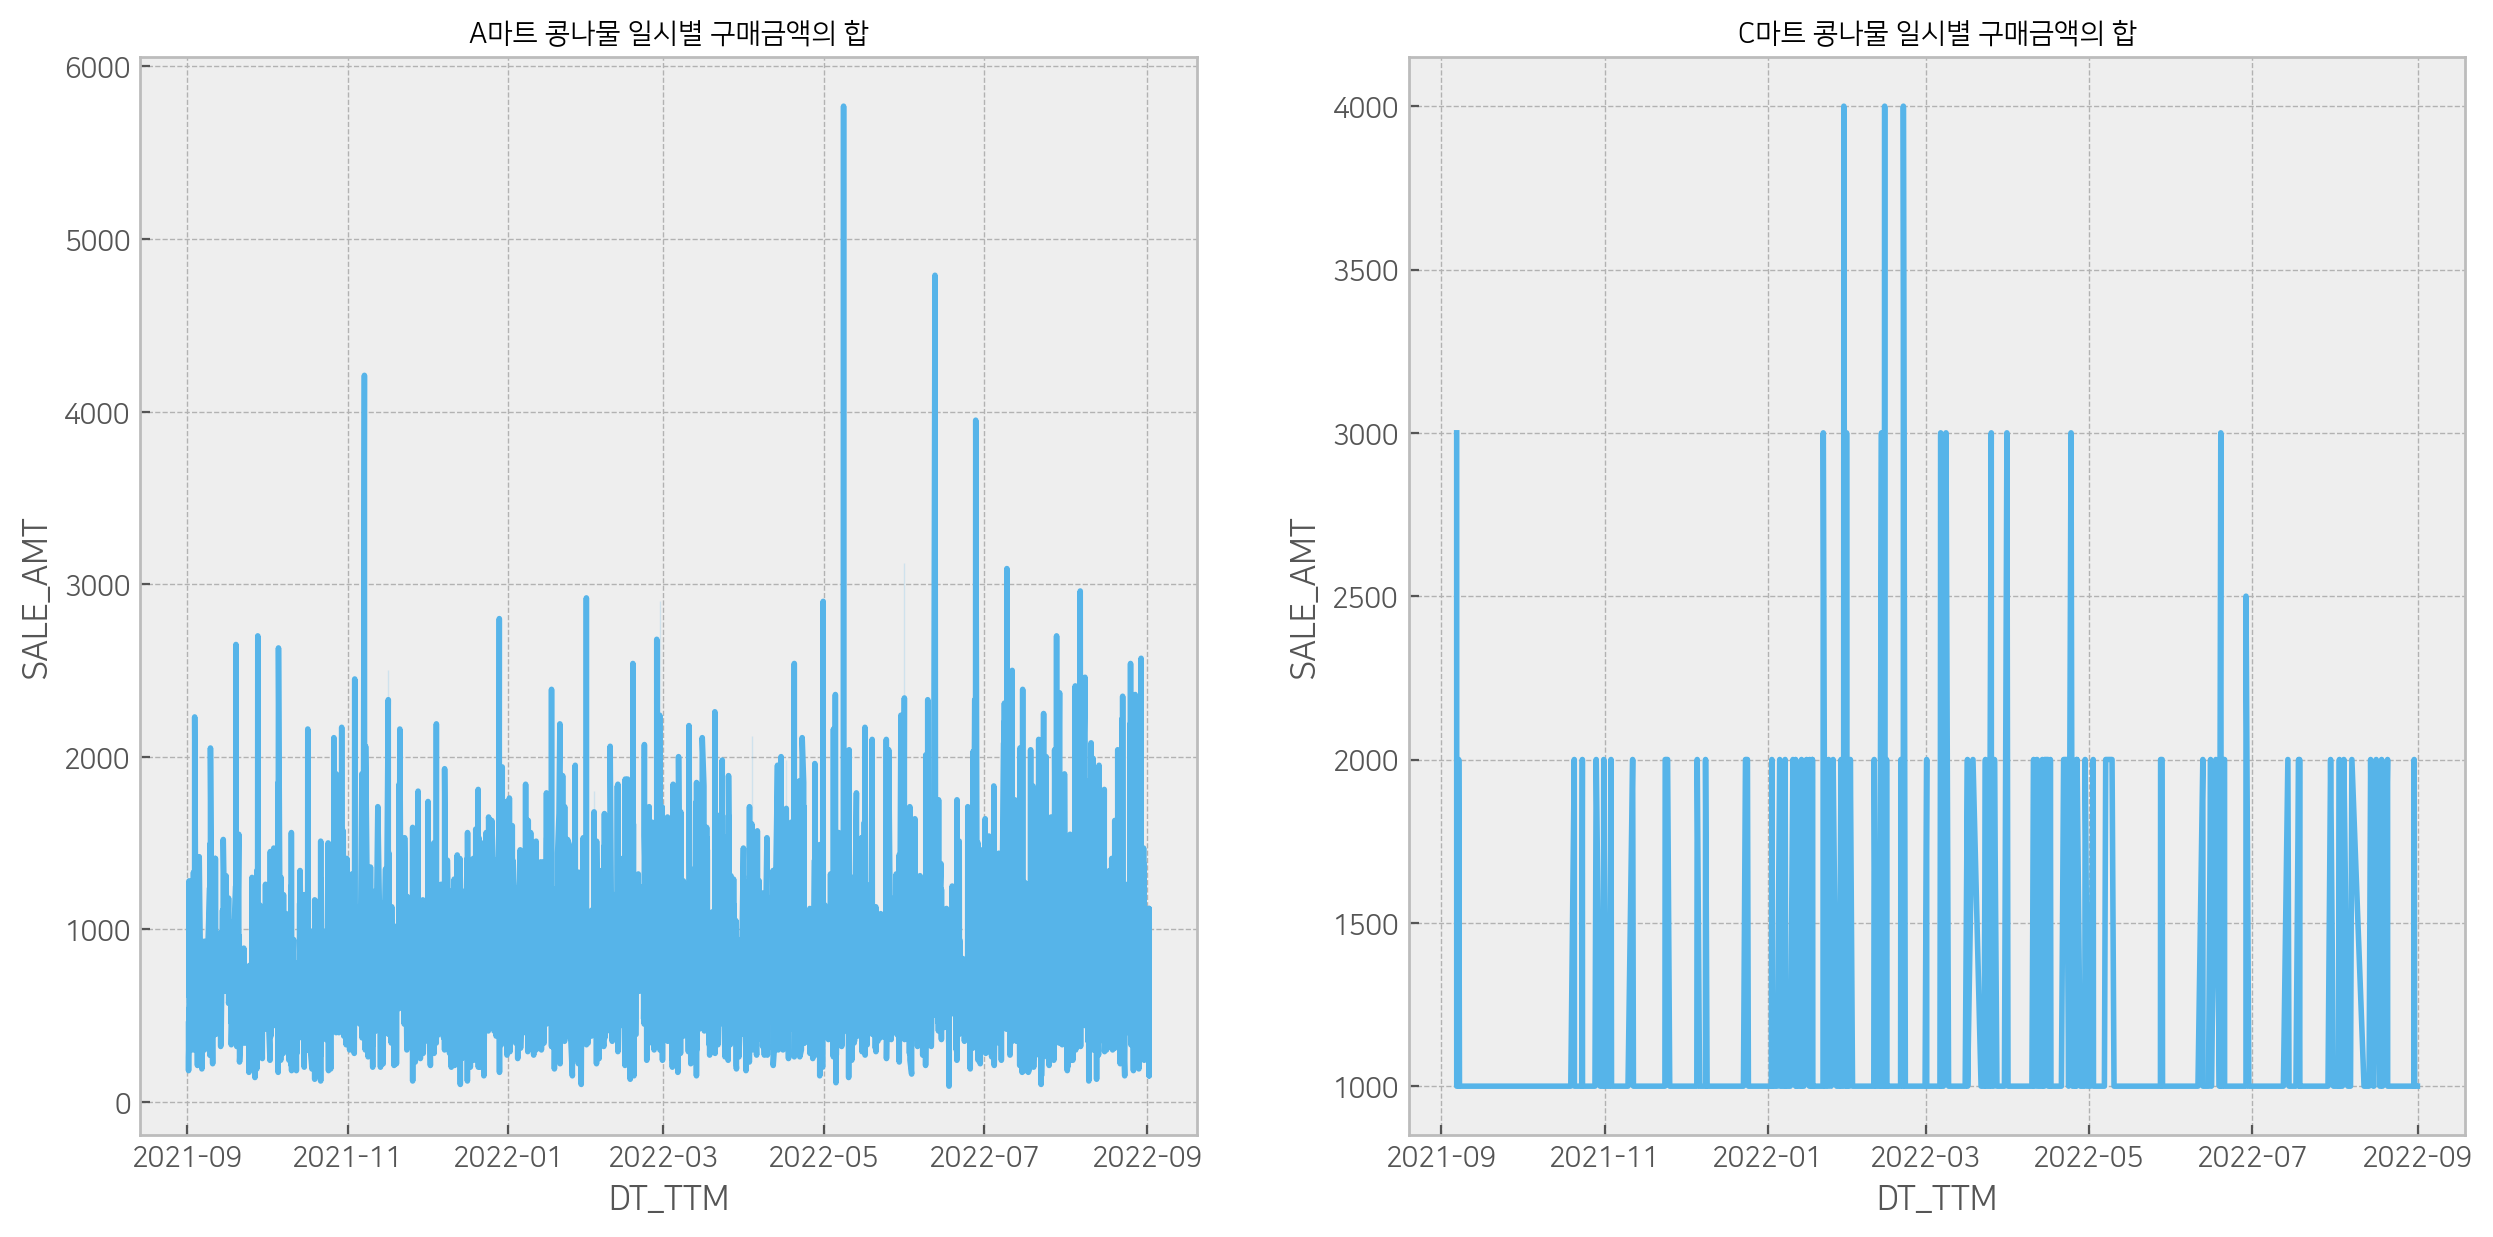

In [16]:
plt.figure(figsize=(15,7))
plt.style.use('bmh')
plt.rcParams['font.family'] = 'NanumSquare' # plt 한글 폰트 적용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨지는 문제 해결

plt.subplot(121)
plt.title('A마트 콩나물 일시별 구매금액의 합', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_a, x='DT_TTM', y='SALE_AMT', estimator=sum, color='C6') # 일시별 구매금액의 합이 계산됨

plt.subplot(122)
plt.title('C마트 콩나물 일시별 구매금액의 합', size = 10)
# plt.xticks(rotation='90')
sns.lineplot(data=cnm_c, x='DT_TTM', y='SALE_AMT', estimator=sum, color='C6') # 일시별 구매금액의 합이 계산됨

In [17]:
# 매장 목록: str_list
str_list = pd.read_csv('data/str_list.csv')

str_list.loc[[0,2]]

,CO_CD,STR_CD,STR_NM,CM_ITM_NM,POS_QTY,OPN_DT
0,1001294,12018,A마트,100평대,9,20201220
2,1001993,142011,C마트,30평대,1,20210805


- 공산품(ex. CJ 브랜드)이 아니면서 계절성을 타지 않고 정기적으로 소비하는 신선상품(콩나물)을 판매하는 마트(A마트, C마트) 두 곳을 선정
    - 월별, 주(Week)차별, 요일별 거래건수, 일별 판매량과 일별 평균 구매금액을 비교
        - 월별 거래건수: 9월이 공통적으로 최저 거래건수 월로 기록
        - 주(Week)차별 거래건수: 4주차 기준은 특이한 패턴을 보이지 않음, 5주차 기준은 A마트와 C마트가 유사한 패턴을 보임 (But, 5의 순위가 다름)
        - 요일별 거래건수: 월요일이 공통적으로 요일별 거래건수 높은 순위를 보임
        - 일별 판매량: 리테일에서 제공한 2021년 9월부터 2022년 9월 전체기간을 조망하면 A마트는 점진적으로 판매가 증가하는 추세이나, C마트의 경우는 균일한 패턴을 보임
        - 구매금액(평균, 합) 경우에도 이질적인 패턴을 보임
- EDA 결과, 이질적인 추세를 보이기 때문에, 마트 위치, 규모(A마트: 100평대, 포스기 9대 → 대형 매장, C마트: 30평대,포스기 1대 → 소형 매장)에 따른 **공간에 따른 소비계층의 이질성이 있는지**에 대한 가설 설정이 필요함